# Compare cloud and its radiation impact

Author: Ziqi Yin

Last modified: 2024 Dec 10

Table of contents:
* [Maps of JJA mean cloud fraction, LWP, SWd, LWd differences over the GrIS](#first-bullet)
* [Time series of JJA mean cloud fraction averaged over the GrIS](#second-bullet)
* [Maps of JJA mean cloud fraction, LWP, SWd and LWd due to clouds, SWd and LWd, albedo differences over the GrIS](#third-bullet)
* [Maps of JJA mean cloud fraction difference at different levels](#fourth-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from holoviews.operation.datashader import datashade, rasterize, regrid

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

# Use ncl colormaps (https://github.com/hhuangwx/cmaps)
import cmaps

## 1. JJA mean cloud fraction, LWP, SWd, and LWd differences <a class="anchor" id="first-bullet"></a>

### Read data

In [2]:
# f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_nohacks_1pctCO2_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TGCLDLWP_1pctCO2_JJA_yearly.nc')['TGCLDLWP'] #[kg/m2]
f09_nohacks_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_1pctCO2_JJA_yearly.nc')['FSDS'] 
f09_nohacks_1pctCO2_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FLDS_1pctCO2_JJA_yearly.nc')['FLDS'] 
f09_lon = f09_nohacks_1pctCO2_CLDTOT_JJA.lon
f09_lat = f09_nohacks_1pctCO2_CLDTOT_JJA.lat

# 4xext
f09_nohacks_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_nohacks_4xext_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TGCLDLWP_4xext_JJA_yearly.nc')['TGCLDLWP'] #[kg/m2]
f09_nohacks_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_4xext_JJA_yearly.nc')['FSDS'] 
f09_nohacks_4xext_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FLDS_4xext_JJA_yearly.nc')['FLDS'] 

In [3]:
# f09muntjewerf
# 1pctCO2
f09_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'][:140,:,:] #[fraction]
f09_1pctCO2_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TGCLDLWP_1pctCO2_JJA_yearly.nc')['TGCLDLWP'][:140,:,:]
f09_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_1pctCO2_JJA.nc')['FSDS'][:140,:,:]
f09_1pctCO2_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FLDS_1pctCO2_JJA.nc')['FLDS'][:140,:,:]

# 4xext
f09_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_4xext_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TGCLDLWP_4xext_JJA_yearly.nc')['TGCLDLWP']
f09_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_4xext_JJA.nc')['FSDS'] 
f09_4xext_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FLDS_4xext_JJA.nc')['FLDS']

In [4]:
# arctic
# 1pctCO2
ARCTIC_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'] #[fraction]
ARCTIC_1pctCO2_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TGCLDLWP_1pctCO2_JJA_yearly.nc')['TGCLDLWP']
ARCTIC_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_1pctCO2_JJA.nc')['FSDS'] 
ARCTIC_1pctCO2_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FLDS_1pctCO2_JJA.nc')['FLDS'] 

# 4xext
ARCTIC_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
ARCTIC_4xext_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TGCLDLWP_4xext_JJA_yearly.nc')['TGCLDLWP']
ARCTIC_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_4xext_JJA.nc')['FSDS'] 
ARCTIC_4xext_FLDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FLDS_4xext_JJA.nc')['FLDS'] 

In [5]:
f09_nohacks_1pctCO2_4xext_CLDTOT_JJA = xr.concat([f09_nohacks_1pctCO2_CLDTOT_JJA, f09_nohacks_4xext_CLDTOT_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_TGCLDLWP_JJA = xr.concat([f09_nohacks_1pctCO2_TGCLDLWP_JJA, f09_nohacks_4xext_TGCLDLWP_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSDS_JJA = xr.concat([f09_nohacks_1pctCO2_FSDS_JJA, f09_nohacks_4xext_FSDS_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FLDS_JJA = xr.concat([f09_nohacks_1pctCO2_FLDS_JJA, f09_nohacks_4xext_FLDS_JJA], dim='time')

f09_1pctCO2_4xext_CLDTOT_JJA = xr.concat([f09_1pctCO2_CLDTOT_JJA, f09_4xext_CLDTOT_JJA], dim='time')
f09_1pctCO2_4xext_TGCLDLWP_JJA = xr.concat([f09_1pctCO2_TGCLDLWP_JJA, f09_4xext_TGCLDLWP_JJA], dim='time')
f09_1pctCO2_4xext_FSDS_JJA = xr.concat([f09_1pctCO2_FSDS_JJA, f09_4xext_FSDS_JJA], dim='time')
f09_1pctCO2_4xext_FLDS_JJA = xr.concat([f09_1pctCO2_FLDS_JJA, f09_4xext_FLDS_JJA], dim='time')

ARCTIC_1pctCO2_4xext_CLDTOT_JJA = xr.concat([ARCTIC_1pctCO2_CLDTOT_JJA, ARCTIC_4xext_CLDTOT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_TGCLDLWP_JJA = xr.concat([ARCTIC_1pctCO2_TGCLDLWP_JJA, ARCTIC_4xext_TGCLDLWP_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSDS_JJA = xr.concat([ARCTIC_1pctCO2_FSDS_JJA, ARCTIC_4xext_FSDS_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FLDS_JJA = xr.concat([ARCTIC_1pctCO2_FLDS_JJA, ARCTIC_4xext_FLDS_JJA], dim='time')

In [6]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

### Select

In [7]:
f09_nohacks_FSDS_stab = f09_nohacks_1pctCO2_4xext_FSDS_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_FLDS_stab = f09_nohacks_1pctCO2_4xext_FLDS_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_CLDTOT_stab = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_TGCLDLWP_stab = f09_nohacks_1pctCO2_4xext_TGCLDLWP_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_stab = np.mean(f09_nohacks_GrIS_mask[130:150,:,:], axis=0)

f09_FSDS_stab = f09_1pctCO2_4xext_FSDS_JJA[130:150,:,:].mean(dim='time')
f09_FLDS_stab = f09_1pctCO2_4xext_FLDS_JJA[130:150,:,:].mean(dim='time')
f09_CLDTOT_stab = f09_1pctCO2_4xext_CLDTOT_JJA[130:150,:,:].mean(dim='time')
f09_TGCLDLWP_stab = f09_1pctCO2_4xext_TGCLDLWP_JJA[130:150,:,:].mean(dim='time')
f09_GrIS_mask_stab = np.mean(f09_GrIS_mask[130:150,:,:], axis=0)

ARCTIC_FSDS_stab = ARCTIC_1pctCO2_4xext_FSDS_JJA[130:150,:].mean(dim='time')
ARCTIC_FLDS_stab = ARCTIC_1pctCO2_4xext_FLDS_JJA[130:150,:].mean(dim='time')
ARCTIC_CLDTOT_stab = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[130:150,:].mean(dim='time')
ARCTIC_TGCLDLWP_stab = ARCTIC_1pctCO2_4xext_TGCLDLWP_JJA[130:150,:].mean(dim='time')
ARCTIC_GrIS_mask_stab = np.mean(ARCTIC_GrIS_mask[130:150,:], axis=0)

In [8]:
f09_nohacks_FSDS_mid = f09_nohacks_1pctCO2_4xext_FSDS_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_FLDS_mid = f09_nohacks_1pctCO2_4xext_FLDS_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_CLDTOT_mid = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_TGCLDLWP_mid = f09_nohacks_1pctCO2_4xext_TGCLDLWP_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_mid = np.mean(f09_nohacks_GrIS_mask[230:250,:,:], axis=0)

f09_FSDS_mid = f09_1pctCO2_4xext_FSDS_JJA[230:250,:,:].mean(dim='time')
f09_FLDS_mid = f09_1pctCO2_4xext_FLDS_JJA[230:250,:,:].mean(dim='time')
f09_CLDTOT_mid = f09_1pctCO2_4xext_CLDTOT_JJA[230:250,:,:].mean(dim='time')
f09_TGCLDLWP_mid = f09_1pctCO2_4xext_TGCLDLWP_JJA[230:250,:,:].mean(dim='time')
f09_GrIS_mask_mid = np.mean(f09_GrIS_mask[230:250,:,:], axis=0)

ARCTIC_FSDS_mid = ARCTIC_1pctCO2_4xext_FSDS_JJA[230:250,:].mean(dim='time')
ARCTIC_FLDS_mid = ARCTIC_1pctCO2_4xext_FLDS_JJA[230:250,:].mean(dim='time')
ARCTIC_CLDTOT_mid = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[230:250,:].mean(dim='time')
ARCTIC_TGCLDLWP_mid = ARCTIC_1pctCO2_4xext_TGCLDLWP_JJA[230:250,:].mean(dim='time')
ARCTIC_GrIS_mask_mid = np.mean(ARCTIC_GrIS_mask[230:250,:], axis=0)

In [9]:
f09_nohacks_FSDS_end = f09_nohacks_1pctCO2_4xext_FSDS_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_FLDS_end = f09_nohacks_1pctCO2_4xext_FLDS_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_CLDTOT_end = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_TGCLDLWP_end = f09_nohacks_1pctCO2_4xext_TGCLDLWP_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_end = np.mean(f09_nohacks_GrIS_mask[-20:,:,:], axis=0)

f09_FSDS_end = f09_1pctCO2_4xext_FSDS_JJA[-20:,:,:].mean(dim='time')
f09_FLDS_end = f09_1pctCO2_4xext_FLDS_JJA[-20:,:,:].mean(dim='time')
f09_CLDTOT_end = f09_1pctCO2_4xext_CLDTOT_JJA[-20:,:,:].mean(dim='time')
f09_TGCLDLWP_end = f09_1pctCO2_4xext_TGCLDLWP_JJA[-20:,:,:].mean(dim='time')
f09_GrIS_mask_end = np.mean(f09_GrIS_mask[-20:,:,:], axis=0)

ARCTIC_FSDS_end = ARCTIC_1pctCO2_4xext_FSDS_JJA[-20:,:].mean(dim='time')
ARCTIC_FLDS_end = ARCTIC_1pctCO2_4xext_FLDS_JJA[-20:,:].mean(dim='time')
ARCTIC_CLDTOT_end = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[-20:,:].mean(dim='time')
ARCTIC_TGCLDLWP_end = ARCTIC_1pctCO2_4xext_TGCLDLWP_JJA[-20:,:].mean(dim='time')
ARCTIC_GrIS_mask_end = np.mean(ARCTIC_GrIS_mask[-20:,:], axis=0)

### Regrid ARCTIC to f09

In [10]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [11]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [12]:
ESMF.Manager(debug=True);

In [13]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [14]:
ARCTIC2f09_FSDS_stab = f09_FSDS_stab * 0
ARCTIC2f09_FLDS_stab = f09_FLDS_stab * 0
ARCTIC2f09_CLDTOT_stab = f09_CLDTOT_stab * 0
ARCTIC2f09_GrIS_mask_stab = f09_GrIS_mask_stab * 0

ARCTIC2f09_FSDS_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FSDS_stab, f09_centers, f09_corners)
ARCTIC2f09_FLDS_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLDS_stab, f09_centers, f09_corners)
ARCTIC2f09_CLDTOT_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_stab, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_stab, f09_centers, f09_corners)

In [15]:
ARCTIC2f09_FSDS_mid = f09_FSDS_mid * 0
ARCTIC2f09_FLDS_mid = f09_FLDS_mid * 0
ARCTIC2f09_CLDTOT_mid = f09_CLDTOT_mid * 0
ARCTIC2f09_GrIS_mask_mid = f09_GrIS_mask_mid * 0

ARCTIC2f09_FSDS_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FSDS_mid, f09_centers, f09_corners)
ARCTIC2f09_FLDS_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLDS_mid, f09_centers, f09_corners)
ARCTIC2f09_CLDTOT_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_mid, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_mid, f09_centers, f09_corners)

In [16]:
ARCTIC2f09_FSDS_end = f09_FSDS_end * 0
ARCTIC2f09_FLDS_end = f09_FLDS_end * 0
ARCTIC2f09_CLDTOT_end = f09_CLDTOT_end * 0
ARCTIC2f09_GrIS_mask_end = f09_GrIS_mask_end * 0

ARCTIC2f09_FSDS_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FSDS_end, f09_centers, f09_corners)
ARCTIC2f09_FLDS_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLDS_end, f09_centers, f09_corners)
ARCTIC2f09_CLDTOT_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_end, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_end, f09_centers, f09_corners)

#### Only if use mask

In [17]:
# stab
f09_FSDS_stab = f09_FSDS_stab.where(f09_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)
f09_FLDS_stab = f09_FLDS_stab.where(f09_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)

f09_nohacks_FSDS_stab = f09_nohacks_FSDS_stab.where(f09_nohacks_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)
f09_nohacks_FLDS_stab = f09_nohacks_FLDS_stab.where(f09_nohacks_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)

# mid
f09_FSDS_mid = f09_FSDS_mid.where(f09_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)
f09_FLDS_mid = f09_FLDS_mid.where(f09_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)

f09_nohacks_FSDS_mid = f09_nohacks_FSDS_mid.where(f09_nohacks_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)
f09_nohacks_FLDS_mid = f09_nohacks_FLDS_mid.where(f09_nohacks_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)

# end
f09_FSDS_end = f09_FSDS_end.where(f09_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)
f09_FLDS_end = f09_FLDS_end.where(f09_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)

f09_nohacks_FSDS_end = f09_nohacks_FSDS_end.where(f09_nohacks_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)
f09_nohacks_FLDS_end = f09_nohacks_FLDS_end.where(f09_nohacks_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)

### Calculate

#### year 131-150

In [18]:
## Calculate difference
f09_ARCTIC_FSDS_diff_stab = f09_FSDS_stab - ARCTIC2f09_FSDS_stab
f09_nohacks_ARCTIC_FSDS_diff_stab = f09_nohacks_FSDS_stab - ARCTIC2f09_FSDS_stab
f09_ARCTIC_FLDS_diff_stab = f09_FLDS_stab - ARCTIC2f09_FLDS_stab
f09_nohacks_ARCTIC_FLDS_diff_stab = f09_nohacks_FLDS_stab - ARCTIC2f09_FLDS_stab
f09_ARCTIC_CLDTOT_diff_stab = f09_CLDTOT_stab - ARCTIC2f09_CLDTOT_stab
f09_nohacks_ARCTIC_CLDTOT_diff_stab = f09_nohacks_CLDTOT_stab - ARCTIC2f09_CLDTOT_stab
f09_ARCTIC_TGCLDLWP_diff_stab = f09_TGCLDLWP_stab.values - ARCTIC_TGCLDLWP_stab.values
f09_nohacks_ARCTIC_TGCLDLWP_diff_stab = f09_nohacks_TGCLDLWP_stab.values - ARCTIC_TGCLDLWP_stab.values

In [19]:
## Add cyclic points
f09_ARCTIC_FSDS_diff_stab2, f09_lon2 = add_cyclic_point(f09_ARCTIC_FSDS_diff_stab, coord=f09_lon)
f09_nohacks_ARCTIC_FSDS_diff_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_FSDS_diff_stab, coord=f09_lon)
f09_ARCTIC_FLDS_diff_stab2, f09_lon2 = add_cyclic_point(f09_ARCTIC_FLDS_diff_stab, coord=f09_lon)
f09_nohacks_ARCTIC_FLDS_diff_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_FLDS_diff_stab, coord=f09_lon)
f09_ARCTIC_CLDTOT_diff_stab2, f09_lon2 = add_cyclic_point(f09_ARCTIC_CLDTOT_diff_stab, coord=f09_lon)
f09_nohacks_ARCTIC_CLDTOT_diff_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_CLDTOT_diff_stab, coord=f09_lon)
f09_ARCTIC_TGCLDLWP_diff_stab2, f09_lon2 = add_cyclic_point(f09_ARCTIC_TGCLDLWP_diff_stab, coord=f09_lon)
f09_nohacks_ARCTIC_TGCLDLWP_diff_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_TGCLDLWP_diff_stab, coord=f09_lon)

#### year 231-250

In [20]:
## Calculate difference
f09_ARCTIC_FSDS_diff_mid = f09_FSDS_mid - ARCTIC2f09_FSDS_mid
f09_nohacks_ARCTIC_FSDS_diff_mid = f09_nohacks_FSDS_mid - ARCTIC2f09_FSDS_mid
f09_ARCTIC_FLDS_diff_mid = f09_FLDS_mid - ARCTIC2f09_FLDS_mid
f09_nohacks_ARCTIC_FLDS_diff_mid = f09_nohacks_FLDS_mid - ARCTIC2f09_FLDS_mid
f09_ARCTIC_CLDTOT_diff_mid = f09_CLDTOT_mid - ARCTIC2f09_CLDTOT_mid
f09_nohacks_ARCTIC_CLDTOT_diff_mid = f09_nohacks_CLDTOT_mid - ARCTIC2f09_CLDTOT_mid
f09_ARCTIC_TGCLDLWP_diff_mid = f09_TGCLDLWP_mid.values - ARCTIC_TGCLDLWP_mid.values
f09_nohacks_ARCTIC_TGCLDLWP_diff_mid = f09_nohacks_TGCLDLWP_mid.values - ARCTIC_TGCLDLWP_mid.values

In [21]:
## Add cyclic points
f09_ARCTIC_FSDS_diff_mid2, f09_lon2 = add_cyclic_point(f09_ARCTIC_FSDS_diff_mid, coord=f09_lon)
f09_nohacks_ARCTIC_FSDS_diff_mid2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_FSDS_diff_mid, coord=f09_lon)
f09_ARCTIC_FLDS_diff_mid2, f09_lon2 = add_cyclic_point(f09_ARCTIC_FLDS_diff_mid, coord=f09_lon)
f09_nohacks_ARCTIC_FLDS_diff_mid2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_FLDS_diff_mid, coord=f09_lon)
f09_ARCTIC_CLDTOT_diff_mid2, f09_lon2 = add_cyclic_point(f09_ARCTIC_CLDTOT_diff_mid, coord=f09_lon)
f09_nohacks_ARCTIC_CLDTOT_diff_mid2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_CLDTOT_diff_mid, coord=f09_lon)
f09_ARCTIC_TGCLDLWP_diff_mid2, f09_lon2 = add_cyclic_point(f09_ARCTIC_TGCLDLWP_diff_mid, coord=f09_lon)
f09_nohacks_ARCTIC_TGCLDLWP_diff_mid2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_TGCLDLWP_diff_mid, coord=f09_lon)

#### year 331-350

In [22]:
## Calculate difference
f09_ARCTIC_FSDS_diff_end = f09_FSDS_end - ARCTIC2f09_FSDS_end
f09_nohacks_ARCTIC_FSDS_diff_end = f09_nohacks_FSDS_end - ARCTIC2f09_FSDS_end
f09_ARCTIC_FLDS_diff_end = f09_FLDS_end - ARCTIC2f09_FLDS_end
f09_nohacks_ARCTIC_FLDS_diff_end = f09_nohacks_FLDS_end - ARCTIC2f09_FLDS_end
f09_ARCTIC_CLDTOT_diff_end = f09_CLDTOT_end - ARCTIC2f09_CLDTOT_end
f09_nohacks_ARCTIC_CLDTOT_diff_end = f09_nohacks_CLDTOT_end - ARCTIC2f09_CLDTOT_end
f09_ARCTIC_TGCLDLWP_diff_end = f09_TGCLDLWP_end.values - ARCTIC_TGCLDLWP_end.values
f09_nohacks_ARCTIC_TGCLDLWP_diff_end = f09_nohacks_TGCLDLWP_end.values - ARCTIC_TGCLDLWP_end.values

In [23]:
## Add cyclic points
f09_ARCTIC_FSDS_diff_end2, f09_lon2 = add_cyclic_point(f09_ARCTIC_FSDS_diff_end, coord=f09_lon)
f09_nohacks_ARCTIC_FSDS_diff_end2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_FSDS_diff_end, coord=f09_lon)
f09_ARCTIC_FLDS_diff_end2, f09_lon2 = add_cyclic_point(f09_ARCTIC_FLDS_diff_end, coord=f09_lon)
f09_nohacks_ARCTIC_FLDS_diff_end2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_FLDS_diff_end, coord=f09_lon)
f09_ARCTIC_CLDTOT_diff_end2, f09_lon2 = add_cyclic_point(f09_ARCTIC_CLDTOT_diff_end, coord=f09_lon)
f09_nohacks_ARCTIC_CLDTOT_diff_end2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_CLDTOT_diff_end, coord=f09_lon)
f09_ARCTIC_TGCLDLWP_diff_end2, f09_lon2 = add_cyclic_point(f09_ARCTIC_TGCLDLWP_diff_end, coord=f09_lon)
f09_nohacks_ARCTIC_TGCLDLWP_diff_end2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_TGCLDLWP_diff_end, coord=f09_lon)

### Plot

In [24]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

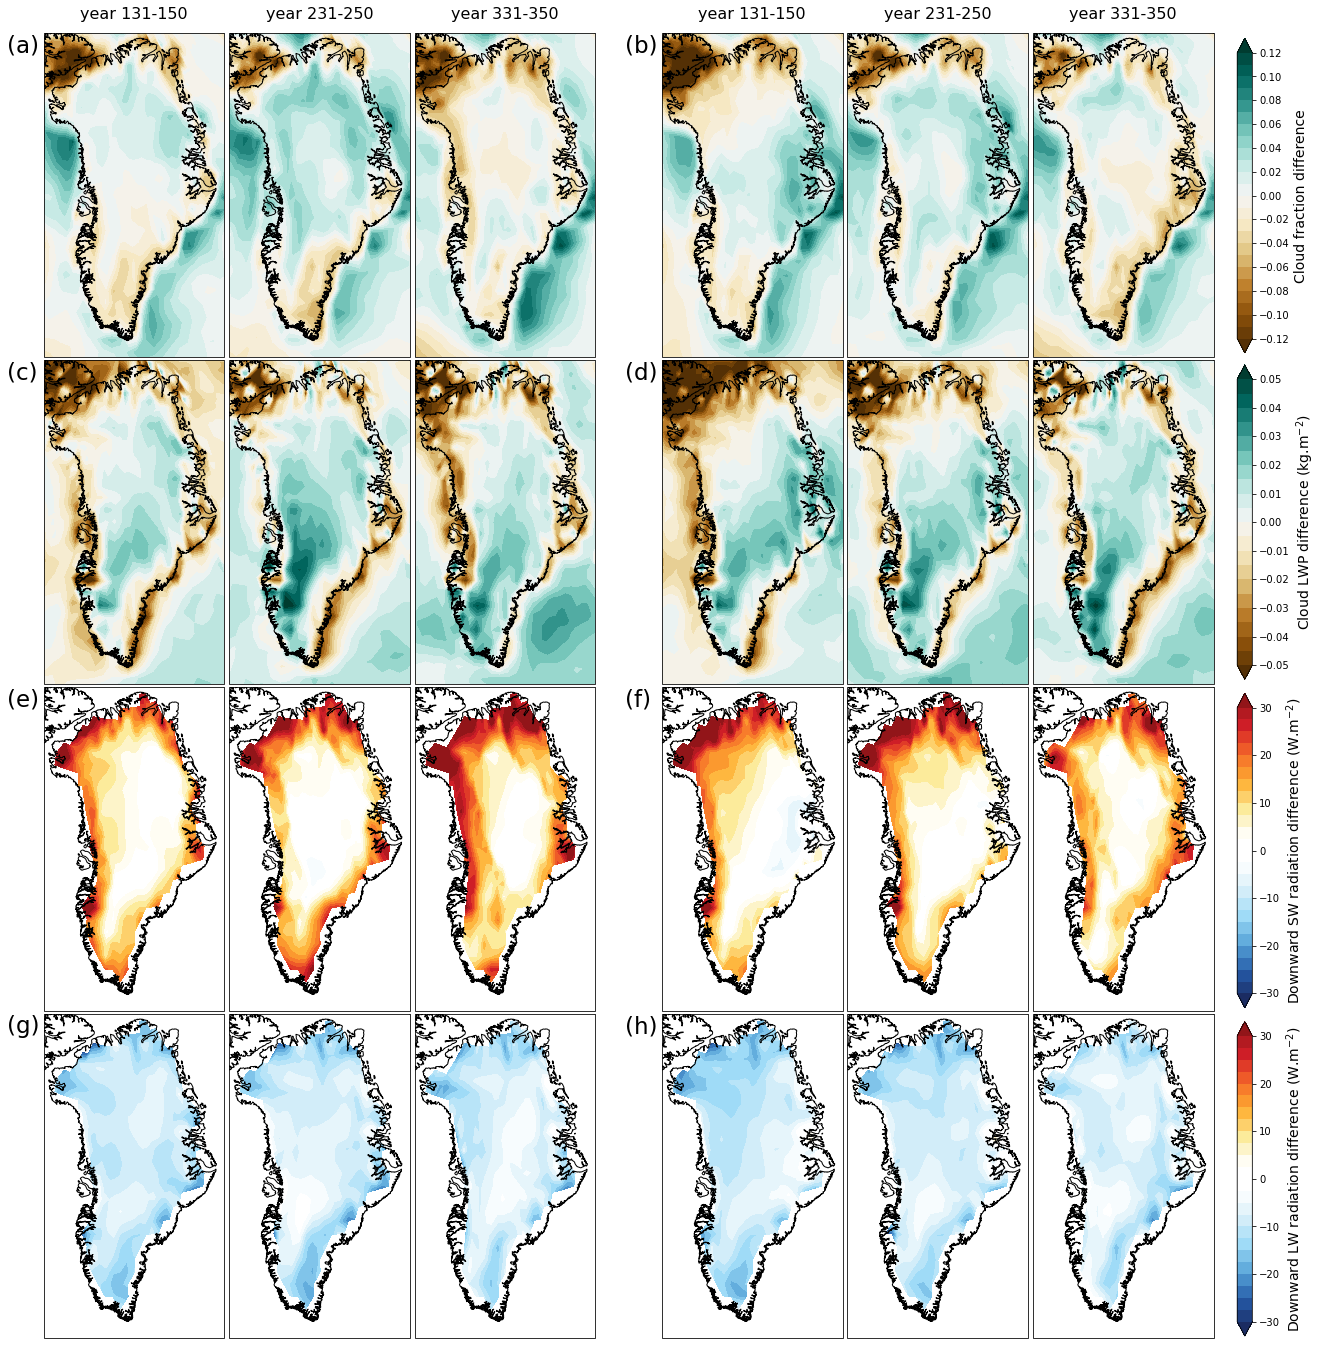

In [25]:
# Revision, change colorbar
fig = plt.figure(figsize = (21,24))
gs=GridSpec(12,19)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.BrBG
bounds1 = np.arange(-0.12,0.121,0.01)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-0.12,0.121,0.02)

cmap2 = plt.cm.BrBG
bounds2 = np.arange(-0.05,0.051,0.005)
bounds2min = [-10]
bounds2max = [10]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-0.05,0.051,0.01)

cmap4 = cmaps.BlueWhiteOrangeRed
bounds4 = np.arange(-30.,30.1,2.5)
bounds4min = [-1000]
bounds4max = [1000]
norm4 = mpl.colors.BoundaryNorm(bounds4, cmap4.N, extend='both')
ticks4 = np.arange(-30.,30.1,10.)

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0:3,0:3], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon2, f09_lat, -f09_ARCTIC_CLDTOT_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax1.text(-1000000, -800000, '(a)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax2 = plt.subplot(gs[0:3,3:6], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon2, f09_lat, -f09_ARCTIC_CLDTOT_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax3 = plt.subplot(gs[0:3,6:9], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon2, f09_lat, -f09_ARCTIC_CLDTOT_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

ax4 = plt.subplot(gs[0:3,10:13], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_CLDTOT_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax4.text(-1000000, -800000, '(b)', fontsize=23)

ax5 = plt.subplot(gs[0:3,13:16], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_CLDTOT_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax6 = plt.subplot(gs[0:3,16:19], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_CLDTOT_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.695, 0.01, 0.182])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb6.set_label(label='Cloud fraction difference', size=14)
cb6.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax7 = plt.subplot(gs[3:6,0:3], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.contourf(f09_lon2, f09_lat, -f09_ARCTIC_TGCLDLWP_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-1000000, -800000, '(c)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax8 = plt.subplot(gs[3:6,3:6], projection=polar_stereographic)
ax8.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.contourf(f09_lon2, f09_lat, -f09_ARCTIC_TGCLDLWP_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax9 = plt.subplot(gs[3:6,6:9], projection=polar_stereographic)
ax9.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax9.coastlines(resolution='10m', zorder=7)
im9 = ax9.contourf(f09_lon2, f09_lat, -f09_ARCTIC_TGCLDLWP_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax10 = plt.subplot(gs[3:6,10:13], projection=polar_stereographic)
ax10.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_TGCLDLWP_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-1000000, -800000, '(d)', fontsize=23)

ax11 = plt.subplot(gs[3:6,13:16], projection=polar_stereographic)
ax11.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_TGCLDLWP_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax12 = plt.subplot(gs[3:6,16:19], projection=polar_stereographic)
ax12.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax12.coastlines(resolution='10m', zorder=7)
im12 = ax12.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_TGCLDLWP_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.506, 0.01, 0.182])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Cloud LWP difference (kg.$\mathregular{m^{-2}}$)', size=14)
cb12.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax13 = plt.subplot(gs[6:9,0:3], projection=polar_stereographic)
ax13.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax13.coastlines(resolution='10m', zorder=7)
im13 = ax13.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FSDS_diff_stab2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(-1000000, -800000, '(e)', fontsize=23)

ax14 = plt.subplot(gs[6:9,3:6], projection=polar_stereographic)
ax14.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax14.coastlines(resolution='10m', zorder=7)
im14 = ax14.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FSDS_diff_mid2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax15 = plt.subplot(gs[6:9,6:9], projection=polar_stereographic)
ax15.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax15.coastlines(resolution='10m', zorder=7)
im15 = ax15.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FSDS_diff_end2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax16 = plt.subplot(gs[6:9,10:13], projection=polar_stereographic)
ax16.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax16.coastlines(resolution='10m', zorder=7)
im16 = ax16.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FSDS_diff_stab2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(-1000000, -800000, '(f)', fontsize=23)

ax17 = plt.subplot(gs[6:9,13:16], projection=polar_stereographic)
ax17.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax17.coastlines(resolution='10m', zorder=7)
im17 = ax17.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FSDS_diff_mid2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax17.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax17.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax18 = plt.subplot(gs[6:9,16:19], projection=polar_stereographic)
ax18.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax18.coastlines(resolution='10m', zorder=7)
im18 = ax18.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FSDS_diff_end2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax18.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax18.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax18 = fig.add_axes([0.915, 0.316, 0.01, 0.182])
cb18 = fig.colorbar(im18, cax=cbar_ax18, orientation='vertical', boundaries=bounds4min+bounds4+bounds4max, ticks=ticks4)
cb18.set_label(label='Downward SW radiation difference (W.$\mathregular{m^{-2}}$)', size=14)
cb18.ax.tick_params(labelsize=10)

#----------------------------line 4----------------------------
ax19 = plt.subplot(gs[9:12,0:3], projection=polar_stereographic)
ax19.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax19.coastlines(resolution='10m', zorder=7)
im19 = ax19.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FLDS_diff_stab2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax19.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax19.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax19.text(-1000000, -800000, '(g)', fontsize=23)

ax20 = plt.subplot(gs[9:12,3:6], projection=polar_stereographic)
ax20.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax20.coastlines(resolution='10m', zorder=7)
im20 = ax20.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FLDS_diff_mid2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax20.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax20.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax21 = plt.subplot(gs[9:12,6:9], projection=polar_stereographic)
ax21.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax21.coastlines(resolution='10m', zorder=7)
im21 = ax21.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FLDS_diff_end2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax21.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax22 = plt.subplot(gs[9:12,10:13], projection=polar_stereographic)
ax22.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax22.coastlines(resolution='10m', zorder=7)
im22 = ax22.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FLDS_diff_stab2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax22.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax22.text(-1000000, -800000, '(h)', fontsize=23)

ax23 = plt.subplot(gs[9:12,13:16], projection=polar_stereographic)
ax23.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax23.coastlines(resolution='10m', zorder=7)
im23 = ax23.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FLDS_diff_mid2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax23.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax23.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax24 = plt.subplot(gs[9:12,16:19], projection=polar_stereographic)
ax24.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax24.coastlines(resolution='10m', zorder=7)
im24 = ax24.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FLDS_diff_end2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax24.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax24.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax24 = fig.add_axes([0.915, 0.126, 0.01, 0.182])
cb24 = fig.colorbar(im24, cax=cbar_ax24, orientation='vertical', boundaries=bounds4min+bounds4+bounds4max, ticks=ticks4)
cb24.set_label(label='Downward LW radiation difference (W.$\mathregular{m^{-2}}$)', size=14)
cb24.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_cloudfrac_LWP_SWd_LWd_diff_2411.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

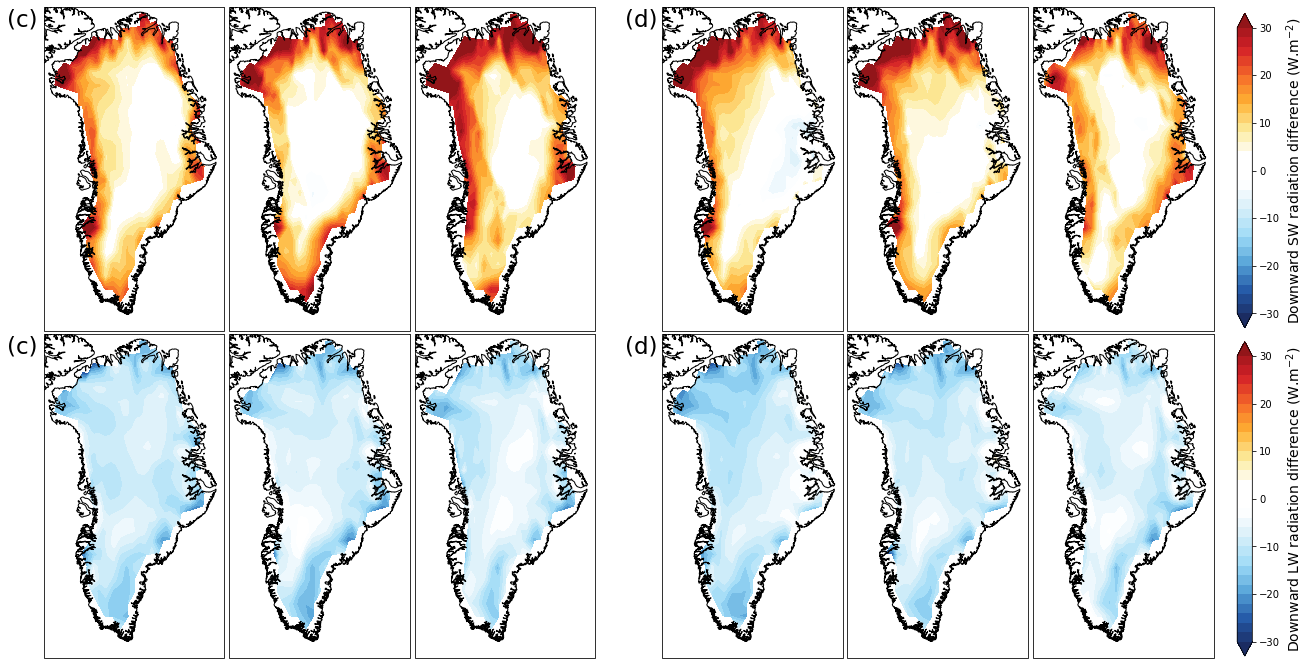

In [27]:
# SWd and LWd
fig = plt.figure(figsize = (21,24))
gs=GridSpec(12,19)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.BrBG
bounds1 = np.arange(-0.12,0.121,0.01)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-0.12,0.121,0.02)

cmap2 = plt.cm.BrBG
bounds2 = np.arange(-0.05,0.051,0.005)
bounds2min = [-10]
bounds2max = [10]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-0.05,0.051,0.01)

cmap3 = cmaps.BlueWhiteOrangeRed
bounds3 = np.arange(-30.,30.1,2.)
bounds3min = [-1000]
bounds3max = [1000]
norm3 = mpl.colors.BoundaryNorm(bounds3, cmap3.N, extend='both')
ticks3 = np.arange(-30.,30.1,10.)

cmap4 = cmaps.BlueWhiteOrangeRed
#bounds4 = np.arange(-5.,5.1,0.5)
bounds4 = np.arange(-30.,30.1,2.)
bounds4min = [-1000]
bounds4max = [1000]
norm4 = mpl.colors.BoundaryNorm(bounds4, cmap4.N, extend='both')
#ticks4 = np.arange(-5.,5.1,1.)
ticks4 = np.arange(-30.,30.1,10.)

#----------------------------line 1----------------------------
#----------------------------line 2----------------------------
#----------------------------line 3----------------------------
ax13 = plt.subplot(gs[6:9,0:3], projection=polar_stereographic)
ax13.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax13.coastlines(resolution='10m', zorder=7)
im13 = ax13.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FSDS_diff_stab2, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(-1000000, -800000, '(c)', fontsize=23)

ax14 = plt.subplot(gs[6:9,3:6], projection=polar_stereographic)
ax14.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax14.coastlines(resolution='10m', zorder=7)
im14 = ax14.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FSDS_diff_mid2, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax15 = plt.subplot(gs[6:9,6:9], projection=polar_stereographic)
ax15.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax15.coastlines(resolution='10m', zorder=7)
im15 = ax15.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FSDS_diff_end2, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax16 = plt.subplot(gs[6:9,10:13], projection=polar_stereographic)
ax16.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax16.coastlines(resolution='10m', zorder=7)
im16 = ax16.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FSDS_diff_stab2, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(-1000000, -800000, '(d)', fontsize=23)

ax17 = plt.subplot(gs[6:9,13:16], projection=polar_stereographic)
ax17.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax17.coastlines(resolution='10m', zorder=7)
im17 = ax17.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FSDS_diff_mid2, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax17.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax17.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax18 = plt.subplot(gs[6:9,16:19], projection=polar_stereographic)
ax18.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax18.coastlines(resolution='10m', zorder=7)
im18 = ax18.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FSDS_diff_end2, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax18.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax18.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax18 = fig.add_axes([0.915, 0.316, 0.01, 0.182])
cb18 = fig.colorbar(im18, cax=cbar_ax18, orientation='vertical', boundaries=bounds3min+bounds3+bounds3max, ticks=ticks3)
cb18.set_label(label='Downward SW radiation difference (W.$\mathregular{m^{-2}}$)', size=14)
cb18.ax.tick_params(labelsize=10)

#----------------------------line 4----------------------------
ax19 = plt.subplot(gs[9:12,0:3], projection=polar_stereographic)
ax19.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax19.coastlines(resolution='10m', zorder=7)
im19 = ax19.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FLDS_diff_stab2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax19.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax19.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax19.text(-1000000, -800000, '(c)', fontsize=23)

ax20 = plt.subplot(gs[9:12,3:6], projection=polar_stereographic)
ax20.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax20.coastlines(resolution='10m', zorder=7)
im20 = ax20.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FLDS_diff_mid2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax20.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax20.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax21 = plt.subplot(gs[9:12,6:9], projection=polar_stereographic)
ax21.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax21.coastlines(resolution='10m', zorder=7)
im21 = ax21.contourf(f09_lon2, f09_lat, -f09_ARCTIC_FLDS_diff_end2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax21.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax22 = plt.subplot(gs[9:12,10:13], projection=polar_stereographic)
ax22.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax22.coastlines(resolution='10m', zorder=7)
im22 = ax22.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FLDS_diff_stab2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax22.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax22.text(-1000000, -800000, '(d)', fontsize=23)

ax23 = plt.subplot(gs[9:12,13:16], projection=polar_stereographic)
ax23.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax23.coastlines(resolution='10m', zorder=7)
im23 = ax23.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FLDS_diff_mid2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax23.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax23.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax24 = plt.subplot(gs[9:12,16:19], projection=polar_stereographic)
ax24.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax24.coastlines(resolution='10m', zorder=7)
im24 = ax24.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_FLDS_diff_end2, cmap=cmap4, norm=norm4, levels=bounds4, extend='both', transform=crs_ll)
ax24.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax24.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax24 = fig.add_axes([0.915, 0.126, 0.01, 0.182])
cb24 = fig.colorbar(im24, cax=cbar_ax24, orientation='vertical', boundaries=bounds4min+bounds4+bounds4max, ticks=ticks4)
cb24.set_label(label='Downward LW radiation difference (W.$\mathregular{m^{-2}}$)', size=14)
cb24.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_SWd_LWd_diff.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## 2. Averaged JJA mean cloud fraction <a class="anchor" id="second-bullet"></a>

### Read data

In [26]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_nohacks_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_1pctCO2_JJA_yearly.nc')['FSDS'] #[W/m2]

# 4xext
f09_nohacks_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_nohacks_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSDS_4xext_JJA_yearly.nc')['FSDS'] #[W/m2]

In [27]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'][:140]
f09_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_1pctCO2_JJA.nc')['FSDS'][:140]

# 4xext
f09_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT']
f09_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSDS_4xext_JJA.nc')['FSDS']

In [28]:
## Arctic
# 1pctCO2
ARCTIC_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT']
ARCTIC_1pctCO2_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_1pctCO2_JJA.nc')['FSDS']

# 4xext
ARCTIC_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] 
ARCTIC_4xext_FSDS_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSDS_4xext_JJA.nc')['FSDS'] 

In [29]:
## Concatenate
f09_nohacks_1pctCO2_4xext_CLDTOT_JJA = xr.concat([f09_nohacks_1pctCO2_CLDTOT_JJA, f09_nohacks_4xext_CLDTOT_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSDS_JJA = xr.concat([f09_nohacks_1pctCO2_FSDS_JJA, f09_nohacks_4xext_FSDS_JJA], dim='time')

f09_1pctCO2_4xext_CLDTOT_JJA = xr.concat([f09_1pctCO2_CLDTOT_JJA, f09_4xext_CLDTOT_JJA], dim='time')
f09_1pctCO2_4xext_FSDS_JJA = xr.concat([f09_1pctCO2_FSDS_JJA, f09_4xext_FSDS_JJA], dim='time')

ARCTIC_1pctCO2_4xext_CLDTOT_JJA = xr.concat([ARCTIC_1pctCO2_CLDTOT_JJA, ARCTIC_4xext_CLDTOT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSDS_JJA = xr.concat([ARCTIC_1pctCO2_FSDS_JJA, ARCTIC_4xext_FSDS_JJA], dim='time')

In [30]:
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area_Arctic = f09_area.where(f09_area.yc > 60).values * Re**2
f09_area = f09_area.values * Re**2

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area_Arctic = ARCTIC_area.where(ARCTIC_area.yc > 60).values * Re**2
ARCTIC_area = ARCTIC_area.values * Re**2

ARCTIC_lat = xr.open_dataset(ARCTIC_mask_file3).yc[0,:].values

In [31]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

### Calculate

In [32]:
f09_avg_1pctCO2_4xext_CLDTOT_JJA = (f09_1pctCO2_4xext_CLDTOT_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) /np.nansum(f09_GrIS_mask * f09_area, axis=(1,2))
f09_nohacks_avg_1pctCO2_4xext_CLDTOT_JJA = (f09_nohacks_1pctCO2_4xext_CLDTOT_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) /np.nansum(f09_nohacks_GrIS_mask * f09_area, axis=(1,2))
ARCTIC_avg_1pctCO2_4xext_CLDTOT_JJA = (ARCTIC_1pctCO2_4xext_CLDTOT_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['ncol']) /np.nansum(ARCTIC_GrIS_mask * ARCTIC_area, axis=1)

f09_avg_1pctCO2_4xext_CLDTOT_JJA_rm = f09_avg_1pctCO2_4xext_CLDTOT_JJA.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_avg_1pctCO2_4xext_CLDTOT_JJA_rm = f09_nohacks_avg_1pctCO2_4xext_CLDTOT_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_CLDTOT_JJA_rm = ARCTIC_avg_1pctCO2_4xext_CLDTOT_JJA.rolling(time=20, center=True, min_periods=2).mean()

In [33]:
f09_avg_1pctCO2_4xext_FSDS_JJA = (f09_1pctCO2_4xext_FSDS_JJA * f09_GrIS_mask * f09_area).sum(dim=['lat','lon']) /np.nansum(f09_GrIS_mask * f09_area, axis=(1,2))
f09_nohacks_avg_1pctCO2_4xext_FSDS_JJA = (f09_nohacks_1pctCO2_4xext_FSDS_JJA * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon']) /np.nansum(f09_nohacks_GrIS_mask * f09_area, axis=(1,2))
ARCTIC_avg_1pctCO2_4xext_FSDS_JJA = (ARCTIC_1pctCO2_4xext_FSDS_JJA * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid']) /np.nansum(ARCTIC_GrIS_mask * ARCTIC_area, axis=1)

f09_avg_1pctCO2_4xext_FSDS_JJA_rm = f09_avg_1pctCO2_4xext_FSDS_JJA.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_avg_1pctCO2_4xext_FSDS_JJA_rm = f09_nohacks_avg_1pctCO2_4xext_FSDS_JJA.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_avg_1pctCO2_4xext_FSDS_JJA_rm = ARCTIC_avg_1pctCO2_4xext_FSDS_JJA.rolling(time=20, center=True, min_periods=2).mean()

### Plot

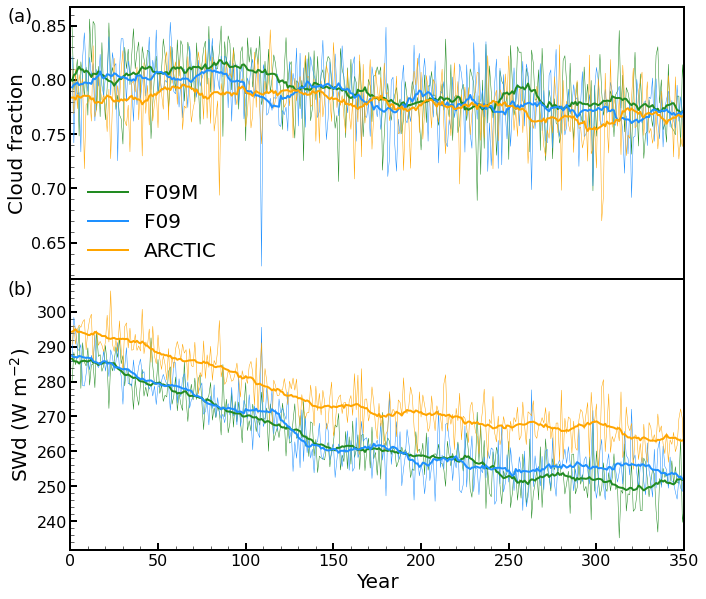

In [34]:
fig = plt.figure(figsize = (11,10))
gs=GridSpec(10,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 20
size_text = 18

year = np.arange(1,351)

#-------------------------------------------- Cloud frac --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:11])

ax1.plot(year, f09_avg_1pctCO2_4xext_CLDTOT_JJA, color='forestgreen', linewidth = 0.5)
ax1.plot(year, f09_nohacks_avg_1pctCO2_4xext_CLDTOT_JJA, color='dodgerblue', linewidth = 0.5)
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_CLDTOT_JJA, color='orange', linewidth = 0.5)

ax1.plot(year, f09_avg_1pctCO2_4xext_CLDTOT_JJA_rm, color='forestgreen', linewidth = 2, label='F09M')
ax1.plot(year, f09_nohacks_avg_1pctCO2_4xext_CLDTOT_JJA_rm, color='dodgerblue', linewidth = 2, label='F09')
ax1.plot(year, ARCTIC_avg_1pctCO2_4xext_CLDTOT_JJA_rm, color='orange', linewidth = 2, label='ARCTIC')

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('Cloud fraction', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.axes.get_xaxis().set_visible(False)
plt.text(-36, 0.854, '(a)', fontsize=size_text)

#-------------------------------------------- SWd --------------------------------------------
ax2 = plt.subplot(gs[5:10,0:11])

ax2.plot(year, f09_avg_1pctCO2_4xext_FSDS_JJA, color='forestgreen', linewidth = 0.5)
ax2.plot(year, f09_nohacks_avg_1pctCO2_4xext_FSDS_JJA, color='dodgerblue', linewidth = 0.5)
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_FSDS_JJA, color='orange', linewidth = 0.5)

ax2.plot(year, f09_avg_1pctCO2_4xext_FSDS_JJA_rm, color='forestgreen', linewidth = 2, label='F09M')
ax2.plot(year, f09_nohacks_avg_1pctCO2_4xext_FSDS_JJA_rm, color='dodgerblue', linewidth = 2, label='F09')
ax2.plot(year, ARCTIC_avg_1pctCO2_4xext_FSDS_JJA_rm, color='orange', linewidth = 2, label='ARCTIC')

ax2.set_xlim([0, 350])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('SWd (W $\mathregular{m^{-2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
plt.text(-36, 305, '(b)', fontsize=size_text)


plt.subplots_adjust(hspace=0)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_avg_cloud_frac_SWd.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

## 3. JJA mean cloud fraction, LWP, SWd and LWd due to clouds, SWd and LWd, albedo differences <a class="anchor" id="third-bullet"></a>

### Read data

In [2]:
# f09muntjewerf
data_dir = '/glade/derecho/scratch/ziqiyin/2022-VR-dynamic-GrIS/'

# 1pctCO2
f09_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'][:140,:,:] #[fraction]
f09_1pctCO2_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TGCLDLWP_1pctCO2_JJA_yearly.nc')['TGCLDLWP'][:140,:,:]
f09_1pctCO2_FSDS_JJA = xr.open_dataset(data_dir+'f09_FSDS_atm_1pctCO2_JJA_yearly.nc')['FSDS'][:140,:,:]
f09_1pctCO2_FLDS_JJA = xr.open_dataset(data_dir+'f09_FLDS_atm_1pctCO2_JJA_yearly.nc')['FLDS'][:140,:,:]
f09_1pctCO2_FSDSC_JJA = xr.open_dataset(data_dir+'f09_FSDSC_atm_1pctCO2_JJA_yearly.nc')['FSDSC'][:140,:,:]
f09_1pctCO2_FLNS_JJA = xr.open_dataset(data_dir+'f09_FLNS_atm_1pctCO2_JJA_yearly.nc')['FLNS'][:140,:,:]
f09_1pctCO2_FLNSC_JJA = xr.open_dataset(data_dir+'f09_FLNSC_atm_1pctCO2_JJA_yearly.nc')['FLNSC'][:140,:,:]
f09_1pctCO2_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSR_1pctCO2_JJA.nc')['FSR'][:140,:,:]
f09_lon = f09_1pctCO2_FLNS_JJA.lon
f09_lat = f09_1pctCO2_FLNS_JJA.lat

# 4xext
f09_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_4xext_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TGCLDLWP_4xext_JJA_yearly.nc')['TGCLDLWP']
f09_4xext_FSDS_JJA = xr.open_dataset(data_dir+'f09_FSDS_atm_4xext_JJA_yearly.nc')['FSDS'] 
f09_4xext_FLDS_JJA = xr.open_dataset(data_dir+'f09_FLDS_atm_4xext_JJA_yearly.nc')['FLDS']
f09_4xext_FSDSC_JJA = xr.open_dataset(data_dir+'f09_FSDSC_atm_4xext_JJA_yearly.nc')['FSDSC']
f09_4xext_FLNS_JJA = xr.open_dataset(data_dir+'f09_FLNS_atm_4xext_JJA_yearly.nc')['FLNS']
f09_4xext_FLNSC_JJA = xr.open_dataset(data_dir+'f09_FLNSC_atm_4xext_JJA_yearly.nc')['FLNSC']
f09_4xext_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_FSR_4xext_JJA.nc')['FSR']

In [3]:
# f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_nohacks_1pctCO2_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TGCLDLWP_1pctCO2_JJA_yearly.nc')['TGCLDLWP'] #[kg/m2]
f09_nohacks_1pctCO2_FSDS_JJA = xr.open_dataset(data_dir+'f09_nohacks_FSDS_atm_1pctCO2_JJA_yearly.nc')['FSDS'] 
f09_nohacks_1pctCO2_FLDS_JJA = xr.open_dataset(data_dir+'f09_nohacks_FLDS_atm_1pctCO2_JJA_yearly.nc')['FLDS'] 
f09_nohacks_1pctCO2_FSDSC_JJA = xr.open_dataset(data_dir+'f09_nohacks_FSDSC_atm_1pctCO2_JJA_yearly.nc')['FSDSC']
f09_nohacks_1pctCO2_FLNS_JJA = xr.open_dataset(data_dir+'f09_nohacks_FLNS_atm_1pctCO2_JJA_yearly.nc')['FLNS']
f09_nohacks_1pctCO2_FLNSC_JJA = xr.open_dataset(data_dir+'f09_nohacks_FLNSC_atm_1pctCO2_JJA_yearly.nc')['FLNSC']
f09_nohacks_1pctCO2_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_1pctCO2_JJA_yearly.nc')['FSR']

# 4xext
f09_nohacks_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_nohacks_4xext_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TGCLDLWP_4xext_JJA_yearly.nc')['TGCLDLWP'] #[kg/m2]
f09_nohacks_4xext_FSDS_JJA = xr.open_dataset(data_dir+'f09_nohacks_FSDS_atm_4xext_JJA_yearly.nc')['FSDS'] 
f09_nohacks_4xext_FLDS_JJA = xr.open_dataset(data_dir+'f09_nohacks_FLDS_atm_4xext_JJA_yearly.nc')['FLDS']
f09_nohacks_4xext_FSDSC_JJA = xr.open_dataset(data_dir+'f09_nohacks_FSDSC_atm_4xext_JJA_yearly.nc')['FSDSC']
f09_nohacks_4xext_FLNS_JJA = xr.open_dataset(data_dir+'f09_nohacks_FLNS_atm_4xext_JJA_yearly.nc')['FLNS']
f09_nohacks_4xext_FLNSC_JJA = xr.open_dataset(data_dir+'f09_nohacks_FLNSC_atm_4xext_JJA_yearly.nc')['FLNSC']
f09_nohacks_4xext_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_FSR_4xext_JJA_yearly.nc')['FSR']

In [4]:
# arctic
# 1pctCO2
ARCTIC_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'] #[fraction]
ARCTIC_1pctCO2_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TGCLDLWP_1pctCO2_JJA_yearly.nc')['TGCLDLWP']
ARCTIC_1pctCO2_FSDS_JJA = xr.open_dataset(data_dir+'ARCTIC_FSDS_atm_1pctCO2_JJA_yearly.nc')['FSDS'] 
ARCTIC_1pctCO2_FLDS_JJA = xr.open_dataset(data_dir+'ARCTIC_FLDS_atm_1pctCO2_JJA_yearly.nc')['FLDS'] 
ARCTIC_1pctCO2_FSDSC_JJA = xr.open_dataset(data_dir+'ARCTIC_FSDSC_atm_1pctCO2_JJA_yearly.nc')['FSDSC']
ARCTIC_1pctCO2_FLNS_JJA = xr.open_dataset(data_dir+'ARCTIC_FLNS_atm_1pctCO2_JJA_yearly.nc')['FLNS']
ARCTIC_1pctCO2_FLNSC_JJA = xr.open_dataset(data_dir+'ARCTIC_FLNSC_atm_1pctCO2_JJA_yearly.nc')['FLNSC']
ARCTIC_1pctCO2_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_1pctCO2_JJA.nc')['FSR']

# 4xext
ARCTIC_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
ARCTIC_4xext_TGCLDLWP_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TGCLDLWP_4xext_JJA_yearly.nc')['TGCLDLWP']
ARCTIC_4xext_FSDS_JJA = xr.open_dataset(data_dir+'ARCTIC_FSDS_atm_4xext_JJA_yearly.nc')['FSDS'] 
ARCTIC_4xext_FLDS_JJA = xr.open_dataset(data_dir+'ARCTIC_FLDS_atm_4xext_JJA_yearly.nc')['FLDS']
ARCTIC_4xext_FSDSC_JJA = xr.open_dataset(data_dir+'ARCTIC_FSDSC_atm_4xext_JJA_yearly.nc')['FSDSC']
ARCTIC_4xext_FLNS_JJA = xr.open_dataset(data_dir+'ARCTIC_FLNS_atm_4xext_JJA_yearly.nc')['FLNS']
ARCTIC_4xext_FLNSC_JJA = xr.open_dataset(data_dir+'ARCTIC_FLNSC_atm_4xext_JJA_yearly.nc')['FLNSC']
ARCTIC_4xext_FSR_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_FSR_4xext_JJA.nc')['FSR']

In [5]:
f09_nohacks_1pctCO2_4xext_CLDTOT_JJA = xr.concat([f09_nohacks_1pctCO2_CLDTOT_JJA, f09_nohacks_4xext_CLDTOT_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_TGCLDLWP_JJA = xr.concat([f09_nohacks_1pctCO2_TGCLDLWP_JJA, f09_nohacks_4xext_TGCLDLWP_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSDS_JJA = xr.concat([f09_nohacks_1pctCO2_FSDS_JJA, f09_nohacks_4xext_FSDS_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FLDS_JJA = xr.concat([f09_nohacks_1pctCO2_FLDS_JJA, f09_nohacks_4xext_FLDS_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSDSC_JJA = xr.concat([f09_nohacks_1pctCO2_FSDSC_JJA, f09_nohacks_4xext_FSDSC_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FLNS_JJA = xr.concat([f09_nohacks_1pctCO2_FLNS_JJA, f09_nohacks_4xext_FLNS_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FLNSC_JJA = xr.concat([f09_nohacks_1pctCO2_FLNSC_JJA, f09_nohacks_4xext_FLNSC_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_FSR_JJA = xr.concat([f09_nohacks_1pctCO2_FSR_JJA, f09_nohacks_4xext_FSR_JJA], dim='time')

f09_1pctCO2_4xext_CLDTOT_JJA = xr.concat([f09_1pctCO2_CLDTOT_JJA, f09_4xext_CLDTOT_JJA], dim='time')
f09_1pctCO2_4xext_TGCLDLWP_JJA = xr.concat([f09_1pctCO2_TGCLDLWP_JJA, f09_4xext_TGCLDLWP_JJA], dim='time')
f09_1pctCO2_4xext_FSDS_JJA = xr.concat([f09_1pctCO2_FSDS_JJA, f09_4xext_FSDS_JJA], dim='time')
f09_1pctCO2_4xext_FLDS_JJA = xr.concat([f09_1pctCO2_FLDS_JJA, f09_4xext_FLDS_JJA], dim='time')
f09_1pctCO2_4xext_FSDSC_JJA = xr.concat([f09_1pctCO2_FSDSC_JJA, f09_4xext_FSDSC_JJA], dim='time')
f09_1pctCO2_4xext_FLNS_JJA = xr.concat([f09_1pctCO2_FLNS_JJA, f09_4xext_FLNS_JJA], dim='time')
f09_1pctCO2_4xext_FLNSC_JJA = xr.concat([f09_1pctCO2_FLNSC_JJA, f09_4xext_FLNSC_JJA], dim='time')
f09_1pctCO2_4xext_FSR_JJA = xr.concat([f09_1pctCO2_FSR_JJA, f09_4xext_FSR_JJA], dim='time')

ARCTIC_1pctCO2_4xext_CLDTOT_JJA = xr.concat([ARCTIC_1pctCO2_CLDTOT_JJA, ARCTIC_4xext_CLDTOT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_TGCLDLWP_JJA = xr.concat([ARCTIC_1pctCO2_TGCLDLWP_JJA, ARCTIC_4xext_TGCLDLWP_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSDS_JJA = xr.concat([ARCTIC_1pctCO2_FSDS_JJA, ARCTIC_4xext_FSDS_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FLDS_JJA = xr.concat([ARCTIC_1pctCO2_FLDS_JJA, ARCTIC_4xext_FLDS_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSDSC_JJA = xr.concat([ARCTIC_1pctCO2_FSDSC_JJA, ARCTIC_4xext_FSDSC_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FLNS_JJA = xr.concat([ARCTIC_1pctCO2_FLNS_JJA, ARCTIC_4xext_FLNS_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FLNSC_JJA = xr.concat([ARCTIC_1pctCO2_FLNSC_JJA, ARCTIC_4xext_FLNSC_JJA], dim='time')
ARCTIC_1pctCO2_4xext_FSR_JJA = xr.concat([ARCTIC_1pctCO2_FSR_JJA, ARCTIC_4xext_FSR_JJA], dim='time')

In [6]:
# Calculate albedo
f09_1pctCO2_4xext_albedo_JJA = f09_1pctCO2_4xext_FSR_JJA.values / f09_1pctCO2_4xext_FSDS_JJA
f09_nohacks_1pctCO2_4xext_albedo_JJA = f09_nohacks_1pctCO2_4xext_FSR_JJA.values / f09_nohacks_1pctCO2_4xext_FSDS_JJA
ARCTIC_1pctCO2_4xext_albedo_JJA = ARCTIC_1pctCO2_4xext_FSR_JJA.values / ARCTIC_1pctCO2_4xext_FSDS_JJA

In [7]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

### Select

In [8]:
f09_nohacks_FSDS_stab = f09_nohacks_1pctCO2_4xext_FSDS_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_FLDS_stab = f09_nohacks_1pctCO2_4xext_FLDS_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_CLDTOT_stab = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_TGCLDLWP_stab = f09_nohacks_1pctCO2_4xext_TGCLDLWP_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_FLNS_stab = f09_nohacks_1pctCO2_4xext_FLNS_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_FLNSC_stab = f09_nohacks_1pctCO2_4xext_FLNSC_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_FSDSC_stab = f09_nohacks_1pctCO2_4xext_FSDSC_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_albedo_stab = f09_nohacks_1pctCO2_4xext_albedo_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_stab = np.mean(f09_nohacks_GrIS_mask[130:150,:,:], axis=0)

f09_FSDS_stab = f09_1pctCO2_4xext_FSDS_JJA[130:150,:,:].mean(dim='time')
f09_FLDS_stab = f09_1pctCO2_4xext_FLDS_JJA[130:150,:,:].mean(dim='time')
f09_CLDTOT_stab = f09_1pctCO2_4xext_CLDTOT_JJA[130:150,:,:].mean(dim='time')
f09_TGCLDLWP_stab = f09_1pctCO2_4xext_TGCLDLWP_JJA[130:150,:,:].mean(dim='time')
f09_FLNS_stab = f09_1pctCO2_4xext_FLNS_JJA[130:150,:,:].mean(dim='time')
f09_FLNSC_stab = f09_1pctCO2_4xext_FLNSC_JJA[130:150,:,:].mean(dim='time')
f09_FSDSC_stab = f09_1pctCO2_4xext_FSDSC_JJA[130:150,:,:].mean(dim='time')
f09_albedo_stab = f09_1pctCO2_4xext_albedo_JJA[130:150,:,:].mean(dim='time')
f09_GrIS_mask_stab = np.mean(f09_GrIS_mask[130:150,:,:], axis=0)

ARCTIC_FSDS_stab = ARCTIC_1pctCO2_4xext_FSDS_JJA[130:150,:].mean(dim='time')
ARCTIC_FLDS_stab = ARCTIC_1pctCO2_4xext_FLDS_JJA[130:150,:].mean(dim='time')
ARCTIC_CLDTOT_stab = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[130:150,:].mean(dim='time')
ARCTIC_TGCLDLWP_stab = ARCTIC_1pctCO2_4xext_TGCLDLWP_JJA[130:150,:].mean(dim='time')
ARCTIC_FLNS_stab = ARCTIC_1pctCO2_4xext_FLNS_JJA[130:150,:].mean(dim='time')
ARCTIC_FLNSC_stab = ARCTIC_1pctCO2_4xext_FLNSC_JJA[130:150,:,:].mean(dim='time')
ARCTIC_FSDSC_stab = ARCTIC_1pctCO2_4xext_FSDSC_JJA[130:150,:,:].mean(dim='time')
ARCTIC_albedo_stab = ARCTIC_1pctCO2_4xext_albedo_JJA[130:150,:].mean(dim='time')
ARCTIC_GrIS_mask_stab = np.mean(ARCTIC_GrIS_mask[130:150,:], axis=0)

In [9]:
f09_nohacks_FSDS_mid = f09_nohacks_1pctCO2_4xext_FSDS_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_FLDS_mid = f09_nohacks_1pctCO2_4xext_FLDS_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_CLDTOT_mid = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_TGCLDLWP_mid = f09_nohacks_1pctCO2_4xext_TGCLDLWP_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_FLNS_mid = f09_nohacks_1pctCO2_4xext_FLNS_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_FLNSC_mid = f09_nohacks_1pctCO2_4xext_FLNSC_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_FSDSC_mid = f09_nohacks_1pctCO2_4xext_FSDSC_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_albedo_mid = f09_nohacks_1pctCO2_4xext_albedo_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_mid = np.mean(f09_nohacks_GrIS_mask[230:250,:,:], axis=0)

f09_FSDS_mid = f09_1pctCO2_4xext_FSDS_JJA[230:250,:,:].mean(dim='time')
f09_FLDS_mid = f09_1pctCO2_4xext_FLDS_JJA[230:250,:,:].mean(dim='time')
f09_CLDTOT_mid = f09_1pctCO2_4xext_CLDTOT_JJA[230:250,:,:].mean(dim='time')
f09_TGCLDLWP_mid = f09_1pctCO2_4xext_TGCLDLWP_JJA[230:250,:,:].mean(dim='time')
f09_FLNS_mid = f09_1pctCO2_4xext_FLNS_JJA[230:250,:,:].mean(dim='time')
f09_FLNSC_mid = f09_1pctCO2_4xext_FLNSC_JJA[230:250,:,:].mean(dim='time')
f09_FSDSC_mid = f09_1pctCO2_4xext_FSDSC_JJA[230:250,:,:].mean(dim='time')
f09_albedo_mid = f09_1pctCO2_4xext_albedo_JJA[230:250,:,:].mean(dim='time')
f09_GrIS_mask_mid = np.mean(f09_GrIS_mask[230:250,:,:], axis=0)

ARCTIC_FSDS_mid = ARCTIC_1pctCO2_4xext_FSDS_JJA[230:250,:].mean(dim='time')
ARCTIC_FLDS_mid = ARCTIC_1pctCO2_4xext_FLDS_JJA[230:250,:].mean(dim='time')
ARCTIC_CLDTOT_mid = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[230:250,:].mean(dim='time')
ARCTIC_TGCLDLWP_mid = ARCTIC_1pctCO2_4xext_TGCLDLWP_JJA[230:250,:].mean(dim='time')
ARCTIC_FLNS_mid = ARCTIC_1pctCO2_4xext_FLNS_JJA[230:250,:].mean(dim='time')
ARCTIC_FLNSC_mid = ARCTIC_1pctCO2_4xext_FLNSC_JJA[230:250,:,:].mean(dim='time')
ARCTIC_FSDSC_mid = ARCTIC_1pctCO2_4xext_FSDSC_JJA[230:250,:,:].mean(dim='time')
ARCTIC_albedo_mid = ARCTIC_1pctCO2_4xext_albedo_JJA[230:250,:].mean(dim='time')
ARCTIC_GrIS_mask_mid = np.mean(ARCTIC_GrIS_mask[230:250,:], axis=0)

In [10]:
f09_nohacks_FSDS_end = f09_nohacks_1pctCO2_4xext_FSDS_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_FLDS_end = f09_nohacks_1pctCO2_4xext_FLDS_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_CLDTOT_end = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_TGCLDLWP_end = f09_nohacks_1pctCO2_4xext_TGCLDLWP_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_FLNS_end = f09_nohacks_1pctCO2_4xext_FLNS_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_FLNSC_end = f09_nohacks_1pctCO2_4xext_FLNSC_JJA[-20:,:,:].mean(dim='time') 
f09_nohacks_FSDSC_end = f09_nohacks_1pctCO2_4xext_FSDSC_JJA[-20:,:,:].mean(dim='time') 
f09_nohacks_albedo_end = f09_nohacks_1pctCO2_4xext_albedo_JJA[-20:,:,:].mean(dim='time') 
f09_nohacks_GrIS_mask_end = np.mean(f09_nohacks_GrIS_mask[-20:,:,:], axis=0)

f09_FSDS_end = f09_1pctCO2_4xext_FSDS_JJA[-20:,:,:].mean(dim='time')
f09_FLDS_end = f09_1pctCO2_4xext_FLDS_JJA[-20:,:,:].mean(dim='time')
f09_CLDTOT_end = f09_1pctCO2_4xext_CLDTOT_JJA[-20:,:,:].mean(dim='time')
f09_TGCLDLWP_end = f09_1pctCO2_4xext_TGCLDLWP_JJA[-20:,:,:].mean(dim='time')
f09_FLNS_end = f09_1pctCO2_4xext_FLNS_JJA[-20:,:,:].mean(dim='time')
f09_FLNSC_end = f09_1pctCO2_4xext_FLNSC_JJA[-20:,:,:].mean(dim='time')
f09_FSDSC_end = f09_1pctCO2_4xext_FSDSC_JJA[-20:,:,:].mean(dim='time')
f09_albedo_end = f09_1pctCO2_4xext_albedo_JJA[-20:,:,:].mean(dim='time')
f09_GrIS_mask_end = np.mean(f09_GrIS_mask[-20:,:,:], axis=0)

ARCTIC_FSDS_end = ARCTIC_1pctCO2_4xext_FSDS_JJA[-20:,:].mean(dim='time')
ARCTIC_FLDS_end = ARCTIC_1pctCO2_4xext_FLDS_JJA[-20:,:].mean(dim='time')
ARCTIC_CLDTOT_end = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[-20:,:].mean(dim='time')
ARCTIC_TGCLDLWP_end = ARCTIC_1pctCO2_4xext_TGCLDLWP_JJA[-20:,:].mean(dim='time')
ARCTIC_FLNS_end = ARCTIC_1pctCO2_4xext_FLNS_JJA[-20:,:].mean(dim='time')
ARCTIC_FLNSC_end = ARCTIC_1pctCO2_4xext_FLNSC_JJA[-20:,:,:].mean(dim='time')
ARCTIC_FSDSC_end = ARCTIC_1pctCO2_4xext_FSDSC_JJA[-20:,:,:].mean(dim='time')
ARCTIC_albedo_end = ARCTIC_1pctCO2_4xext_albedo_JJA[-20:,:].mean(dim='time')
ARCTIC_GrIS_mask_end = np.mean(ARCTIC_GrIS_mask[-20:,:], axis=0)

### Regrid ARCTIC to f09

In [11]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [12]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [13]:
ESMF.Manager(debug=True);

In [14]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [15]:
ARCTIC2f09_FSDS_stab = f09_FSDS_stab * 0
ARCTIC2f09_FLDS_stab = f09_FLDS_stab * 0
ARCTIC2f09_FLNS_stab = f09_FLNS_stab * 0
ARCTIC2f09_CLDTOT_stab = f09_CLDTOT_stab * 0
ARCTIC2f09_GrIS_mask_stab = f09_GrIS_mask_stab * 0
ARCTIC2f09_albedo_stab = f09_albedo_stab * 0

ARCTIC2f09_FSDS_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FSDS_stab, f09_centers, f09_corners)
ARCTIC2f09_FLDS_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLDS_stab, f09_centers, f09_corners)
ARCTIC2f09_FLNS_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLNS_stab, f09_centers, f09_corners)
ARCTIC2f09_CLDTOT_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_stab, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_stab, f09_centers, f09_corners)
ARCTIC2f09_albedo_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_albedo_stab, f09_centers, f09_corners)

In [16]:
ARCTIC2f09_FSDS_mid = f09_FSDS_mid * 0
ARCTIC2f09_FLDS_mid = f09_FLDS_mid * 0
ARCTIC2f09_FLNS_mid = f09_FLNS_mid * 0
ARCTIC2f09_CLDTOT_mid = f09_CLDTOT_mid * 0
ARCTIC2f09_GrIS_mask_mid = f09_GrIS_mask_mid * 0
ARCTIC2f09_albedo_mid = f09_albedo_mid * 0

ARCTIC2f09_FSDS_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FSDS_mid, f09_centers, f09_corners)
ARCTIC2f09_FLDS_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLDS_mid, f09_centers, f09_corners)
ARCTIC2f09_FLNS_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLNS_mid, f09_centers, f09_corners)
ARCTIC2f09_CLDTOT_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_mid, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_mid, f09_centers, f09_corners)
ARCTIC2f09_albedo_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_albedo_mid, f09_centers, f09_corners)

In [17]:
ARCTIC2f09_FSDS_end = f09_FSDS_end * 0
ARCTIC2f09_FLDS_end = f09_FLDS_end * 0
ARCTIC2f09_FLNS_end = f09_FLNS_end * 0
ARCTIC2f09_CLDTOT_end = f09_CLDTOT_end * 0
ARCTIC2f09_GrIS_mask_end = f09_GrIS_mask_end * 0
ARCTIC2f09_albedo_end = f09_albedo_end * 0

ARCTIC2f09_FSDS_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FSDS_end, f09_centers, f09_corners)
ARCTIC2f09_FLDS_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLDS_end, f09_centers, f09_corners)
ARCTIC2f09_FLNS_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_FLNS_end, f09_centers, f09_corners)
ARCTIC2f09_CLDTOT_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_end, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_end, f09_centers, f09_corners)
ARCTIC2f09_albedo_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_albedo_end, f09_centers, f09_corners)

#### Only if use mask

In [17]:
# stab
f09_FSDS_stab = f09_FSDS_stab.where(f09_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)
f09_FLDS_stab = f09_FLDS_stab.where(f09_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)

f09_nohacks_FSDS_stab = f09_nohacks_FSDS_stab.where(f09_nohacks_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)
f09_nohacks_FLDS_stab = f09_nohacks_FLDS_stab.where(f09_nohacks_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)

# mid
f09_FSDS_mid = f09_FSDS_mid.where(f09_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)
f09_FLDS_mid = f09_FLDS_mid.where(f09_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)

f09_nohacks_FSDS_mid = f09_nohacks_FSDS_mid.where(f09_nohacks_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)
f09_nohacks_FLDS_mid = f09_nohacks_FLDS_mid.where(f09_nohacks_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)

# end
f09_FSDS_end = f09_FSDS_end.where(f09_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)
f09_FLDS_end = f09_FLDS_end.where(f09_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)

f09_nohacks_FSDS_end = f09_nohacks_FSDS_end.where(f09_nohacks_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)
f09_nohacks_FLDS_end = f09_nohacks_FLDS_end.where(f09_nohacks_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)

In [18]:
# stab
f09_albedo_stab = f09_albedo_stab.where(f09_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)
f09_nohacks_albedo_stab = f09_nohacks_albedo_stab.where(f09_nohacks_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)

# mid
f09_albedo_mid = f09_albedo_mid.where(f09_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)
f09_nohacks_albedo_mid = f09_nohacks_albedo_mid.where(f09_nohacks_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)

# end
f09_albedo_end = f09_albedo_end.where(f09_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)
f09_nohacks_albedo_end = f09_nohacks_albedo_end.where(f09_nohacks_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)

### Calculate

In [19]:
## Calculate downward LW at the surface clear-sky
f09_FLDSC_stab = f09_FLDS_stab + f09_FLNS_stab - f09_FLNSC_stab
f09_FLDSC_mid = f09_FLDS_mid + f09_FLNS_mid - f09_FLNSC_mid
f09_FLDSC_end = f09_FLDS_end + f09_FLNS_end - f09_FLNSC_end

f09_nohacks_FLDSC_stab = f09_nohacks_FLDS_stab + f09_nohacks_FLNS_stab - f09_nohacks_FLNSC_stab
f09_nohacks_FLDSC_mid = f09_nohacks_FLDS_mid + f09_nohacks_FLNS_mid - f09_nohacks_FLNSC_mid
f09_nohacks_FLDSC_end = f09_nohacks_FLDS_end + f09_nohacks_FLNS_end - f09_nohacks_FLNSC_end

ARCTIC_FLDSC_stab = ARCTIC2f09_FLDS_stab + ARCTIC2f09_FLNS_stab - ARCTIC_FLNSC_stab.values
ARCTIC_FLDSC_mid = ARCTIC2f09_FLDS_mid + ARCTIC2f09_FLNS_mid - ARCTIC_FLNSC_mid.values
ARCTIC_FLDSC_end = ARCTIC2f09_FLDS_end + ARCTIC2f09_FLNS_end - ARCTIC_FLNSC_end.values

In [20]:
## Calculate downward LW at the surface due to clouds
f09_FLDScld_stab = f09_FLNSC_stab - f09_FLNS_stab
f09_FLDScld_mid = f09_FLNSC_mid - f09_FLNS_mid
f09_FLDScld_end = f09_FLNSC_end - f09_FLNS_end

f09_nohacks_FLDScld_stab = f09_nohacks_FLNSC_stab - f09_nohacks_FLNS_stab
f09_nohacks_FLDScld_mid = f09_nohacks_FLNSC_mid - f09_nohacks_FLNS_mid
f09_nohacks_FLDScld_end = f09_nohacks_FLNSC_end - f09_nohacks_FLNS_end

ARCTIC_FLDScld_stab = ARCTIC_FLNSC_stab.values - ARCTIC2f09_FLNS_stab
ARCTIC_FLDScld_mid = ARCTIC_FLNSC_mid.values - ARCTIC2f09_FLNS_mid
ARCTIC_FLDScld_end = ARCTIC_FLNSC_end.values - ARCTIC2f09_FLNS_end

In [21]:
## Calculate downward SW at the surface due to clouds
f09_FSDScld_stab = f09_FSDS_stab - f09_FSDSC_stab
f09_FSDScld_mid = f09_FSDS_mid - f09_FSDSC_mid
f09_FSDScld_end = f09_FSDS_end - f09_FSDSC_end

f09_nohacks_FSDScld_stab = f09_nohacks_FSDS_stab - f09_nohacks_FSDSC_stab
f09_nohacks_FSDScld_mid = f09_nohacks_FSDS_mid - f09_nohacks_FSDSC_mid
f09_nohacks_FSDScld_end = f09_nohacks_FSDS_end - f09_nohacks_FSDSC_end

ARCTIC_FSDScld_stab = ARCTIC2f09_FSDS_stab - ARCTIC_FSDSC_stab.values
ARCTIC_FSDScld_mid = ARCTIC2f09_FSDS_mid - ARCTIC_FSDSC_mid.values
ARCTIC_FSDScld_end = ARCTIC2f09_FSDS_end - ARCTIC_FSDSC_end.values

#### Difference

##### year 131-150

In [22]:
## Calculate difference
ARCTIC_f09_CLDTOT_diff_stab = ARCTIC2f09_CLDTOT_stab - f09_CLDTOT_stab
ARCTIC_f09_nohacks_CLDTOT_diff_stab = ARCTIC2f09_CLDTOT_stab - f09_nohacks_CLDTOT_stab
ARCTIC_f09_TGCLDLWP_diff_stab = ARCTIC_TGCLDLWP_stab.values - f09_TGCLDLWP_stab.values
ARCTIC_f09_nohacks_TGCLDLWP_diff_stab = ARCTIC_TGCLDLWP_stab.values - f09_nohacks_TGCLDLWP_stab.values

ARCTIC_f09_FSDS_diff_stab = ARCTIC2f09_FSDS_stab - f09_FSDS_stab
ARCTIC_f09_nohacks_FSDS_diff_stab = ARCTIC2f09_FSDS_stab - f09_nohacks_FSDS_stab
ARCTIC_f09_FSDScld_diff_stab = ARCTIC_FSDScld_stab - f09_FSDScld_stab
ARCTIC_f09_nohacks_FSDScld_diff_stab = ARCTIC_FSDScld_stab - f09_nohacks_FSDScld_stab
ARCTIC_f09_FSDSC_diff_stab = ARCTIC_FSDSC_stab.values - f09_FSDSC_stab
ARCTIC_f09_nohacks_FSDSC_diff_stab = ARCTIC_FSDSC_stab.values - f09_nohacks_FSDSC_stab
ARCTIC_f09_albedo_diff_stab = ARCTIC2f09_albedo_stab - f09_albedo_stab
ARCTIC_f09_nohacks_albedo_diff_stab = ARCTIC2f09_albedo_stab - f09_nohacks_albedo_stab

ARCTIC_f09_FLDS_diff_stab = ARCTIC2f09_FLDS_stab - f09_FLDS_stab
ARCTIC_f09_nohacks_FLDS_diff_stab = ARCTIC2f09_FLDS_stab - f09_nohacks_FLDS_stab
ARCTIC_f09_FLDScld_diff_stab = ARCTIC_FLDScld_stab - f09_FLDScld_stab
ARCTIC_f09_nohacks_FLDScld_diff_stab = ARCTIC_FLDScld_stab - f09_nohacks_FLDScld_stab
ARCTIC_f09_FLDSC_diff_stab = ARCTIC_FLDSC_stab - f09_FLDSC_stab
ARCTIC_f09_nohacks_FLDSC_diff_stab = ARCTIC_FLDSC_stab - f09_nohacks_FLDSC_stab

In [23]:
## Add cyclic points
ARCTIC_f09_CLDTOT_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDTOT_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_CLDTOT_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDTOT_diff_stab, coord=f09_lon)
ARCTIC_f09_TGCLDLWP_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_TGCLDLWP_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_TGCLDLWP_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_TGCLDLWP_diff_stab, coord=f09_lon)

ARCTIC_f09_FSDS_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDS_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_FSDS_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDS_diff_stab, coord=f09_lon)
ARCTIC_f09_FSDScld_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDScld_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_FSDScld_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDScld_diff_stab, coord=f09_lon)
ARCTIC_f09_FSDSC_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDSC_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_FSDSC_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDSC_diff_stab, coord=f09_lon)
ARCTIC_f09_albedo_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_albedo_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_albedo_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_albedo_diff_stab, coord=f09_lon)

ARCTIC_f09_FLDS_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDS_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_FLDS_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDS_diff_stab, coord=f09_lon)
ARCTIC_f09_FLDScld_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDScld_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_FLDScld_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDScld_diff_stab, coord=f09_lon)
ARCTIC_f09_FLDSC_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDSC_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_FLDSC_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDSC_diff_stab, coord=f09_lon)

##### year 231-250

In [24]:
## Calculate difference
ARCTIC_f09_CLDTOT_diff_mid = ARCTIC2f09_CLDTOT_mid - f09_CLDTOT_mid
ARCTIC_f09_nohacks_CLDTOT_diff_mid = ARCTIC2f09_CLDTOT_mid - f09_nohacks_CLDTOT_mid
ARCTIC_f09_TGCLDLWP_diff_mid = ARCTIC_TGCLDLWP_mid.values - f09_TGCLDLWP_mid.values
ARCTIC_f09_nohacks_TGCLDLWP_diff_mid = ARCTIC_TGCLDLWP_mid.values - f09_nohacks_TGCLDLWP_mid.values

ARCTIC_f09_FSDS_diff_mid = ARCTIC2f09_FSDS_mid - f09_FSDS_mid
ARCTIC_f09_nohacks_FSDS_diff_mid = ARCTIC2f09_FSDS_mid - f09_nohacks_FSDS_mid
ARCTIC_f09_FSDScld_diff_mid = ARCTIC_FSDScld_mid - f09_FSDScld_mid
ARCTIC_f09_nohacks_FSDScld_diff_mid = ARCTIC_FSDScld_mid - f09_nohacks_FSDScld_mid
ARCTIC_f09_FSDSC_diff_mid = ARCTIC_FSDSC_mid.values - f09_FSDSC_mid
ARCTIC_f09_nohacks_FSDSC_diff_mid = ARCTIC_FSDSC_mid.values - f09_nohacks_FSDSC_mid
ARCTIC_f09_albedo_diff_mid = ARCTIC2f09_albedo_mid - f09_albedo_mid
ARCTIC_f09_nohacks_albedo_diff_mid = ARCTIC2f09_albedo_mid - f09_nohacks_albedo_mid

ARCTIC_f09_FLDS_diff_mid = ARCTIC2f09_FLDS_mid - f09_FLDS_mid
ARCTIC_f09_nohacks_FLDS_diff_mid = ARCTIC2f09_FLDS_mid - f09_nohacks_FLDS_mid
ARCTIC_f09_FLDScld_diff_mid = ARCTIC_FLDScld_mid - f09_FLDScld_mid
ARCTIC_f09_nohacks_FLDScld_diff_mid = ARCTIC_FLDScld_mid - f09_nohacks_FLDScld_mid
ARCTIC_f09_FLDSC_diff_mid = ARCTIC_FLDSC_mid - f09_FLDSC_mid
ARCTIC_f09_nohacks_FLDSC_diff_mid = ARCTIC_FLDSC_mid - f09_nohacks_FLDSC_mid

In [25]:
## Add cyclic points
ARCTIC_f09_CLDTOT_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDTOT_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_CLDTOT_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDTOT_diff_mid, coord=f09_lon)
ARCTIC_f09_TGCLDLWP_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_TGCLDLWP_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_TGCLDLWP_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_TGCLDLWP_diff_mid, coord=f09_lon)

ARCTIC_f09_FSDS_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDS_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_FSDS_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDS_diff_mid, coord=f09_lon)
ARCTIC_f09_FSDScld_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDScld_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_FSDScld_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDScld_diff_mid, coord=f09_lon)
ARCTIC_f09_FSDSC_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDSC_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_FSDSC_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDSC_diff_mid, coord=f09_lon)
ARCTIC_f09_albedo_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_albedo_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_albedo_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_albedo_diff_mid, coord=f09_lon)

ARCTIC_f09_FLDS_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDS_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_FLDS_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDS_diff_mid, coord=f09_lon)
ARCTIC_f09_FLDScld_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDScld_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_FLDScld_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDScld_diff_mid, coord=f09_lon)
ARCTIC_f09_FLDSC_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDSC_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_FLDSC_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDSC_diff_mid, coord=f09_lon)

##### year 331-350

In [26]:
## Calculate difference
ARCTIC_f09_CLDTOT_diff_end = ARCTIC2f09_CLDTOT_end - f09_CLDTOT_end
ARCTIC_f09_nohacks_CLDTOT_diff_end = ARCTIC2f09_CLDTOT_end - f09_nohacks_CLDTOT_end
ARCTIC_f09_TGCLDLWP_diff_end = ARCTIC_TGCLDLWP_end.values - f09_TGCLDLWP_end.values
ARCTIC_f09_nohacks_TGCLDLWP_diff_end = ARCTIC_TGCLDLWP_end.values - f09_nohacks_TGCLDLWP_end.values

ARCTIC_f09_FSDS_diff_end = ARCTIC2f09_FSDS_end - f09_FSDS_end
ARCTIC_f09_nohacks_FSDS_diff_end = ARCTIC2f09_FSDS_end - f09_nohacks_FSDS_end
ARCTIC_f09_FSDScld_diff_end = ARCTIC_FSDScld_end - f09_FSDScld_end
ARCTIC_f09_nohacks_FSDScld_diff_end = ARCTIC_FSDScld_end - f09_nohacks_FSDScld_end
ARCTIC_f09_FSDSC_diff_end = ARCTIC_FSDSC_end.values - f09_FSDSC_end
ARCTIC_f09_nohacks_FSDSC_diff_end = ARCTIC_FSDSC_end.values - f09_nohacks_FSDSC_end
ARCTIC_f09_albedo_diff_end = ARCTIC2f09_albedo_end - f09_albedo_end
ARCTIC_f09_nohacks_albedo_diff_end = ARCTIC2f09_albedo_end - f09_nohacks_albedo_end

ARCTIC_f09_FLDS_diff_end = ARCTIC2f09_FLDS_end - f09_FLDS_end
ARCTIC_f09_nohacks_FLDS_diff_end = ARCTIC2f09_FLDS_end - f09_nohacks_FLDS_end
ARCTIC_f09_FLDScld_diff_end = ARCTIC_FLDScld_end - f09_FLDScld_end
ARCTIC_f09_nohacks_FLDScld_diff_end = ARCTIC_FLDScld_end - f09_nohacks_FLDScld_end
ARCTIC_f09_FLDSC_diff_end = ARCTIC_FLDSC_end - f09_FLDSC_end
ARCTIC_f09_nohacks_FLDSC_diff_end = ARCTIC_FLDSC_end - f09_nohacks_FLDSC_end

In [27]:
## Add cyclic points
ARCTIC_f09_CLDTOT_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDTOT_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_CLDTOT_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDTOT_diff_end, coord=f09_lon)
ARCTIC_f09_TGCLDLWP_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_TGCLDLWP_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_TGCLDLWP_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_TGCLDLWP_diff_end, coord=f09_lon)

ARCTIC_f09_FSDS_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDS_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_FSDS_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDS_diff_end, coord=f09_lon)
ARCTIC_f09_FSDScld_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDScld_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_FSDScld_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDScld_diff_end, coord=f09_lon)
ARCTIC_f09_FSDSC_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FSDSC_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_FSDSC_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FSDSC_diff_end, coord=f09_lon)
ARCTIC_f09_albedo_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_albedo_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_albedo_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_albedo_diff_end, coord=f09_lon)

ARCTIC_f09_FLDS_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDS_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_FLDS_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDS_diff_end, coord=f09_lon)
ARCTIC_f09_FLDScld_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDScld_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_FLDScld_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDScld_diff_end, coord=f09_lon)
ARCTIC_f09_FLDSC_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_FLDSC_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_FLDSC_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_FLDSC_diff_end, coord=f09_lon)

### Plot

In [28]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

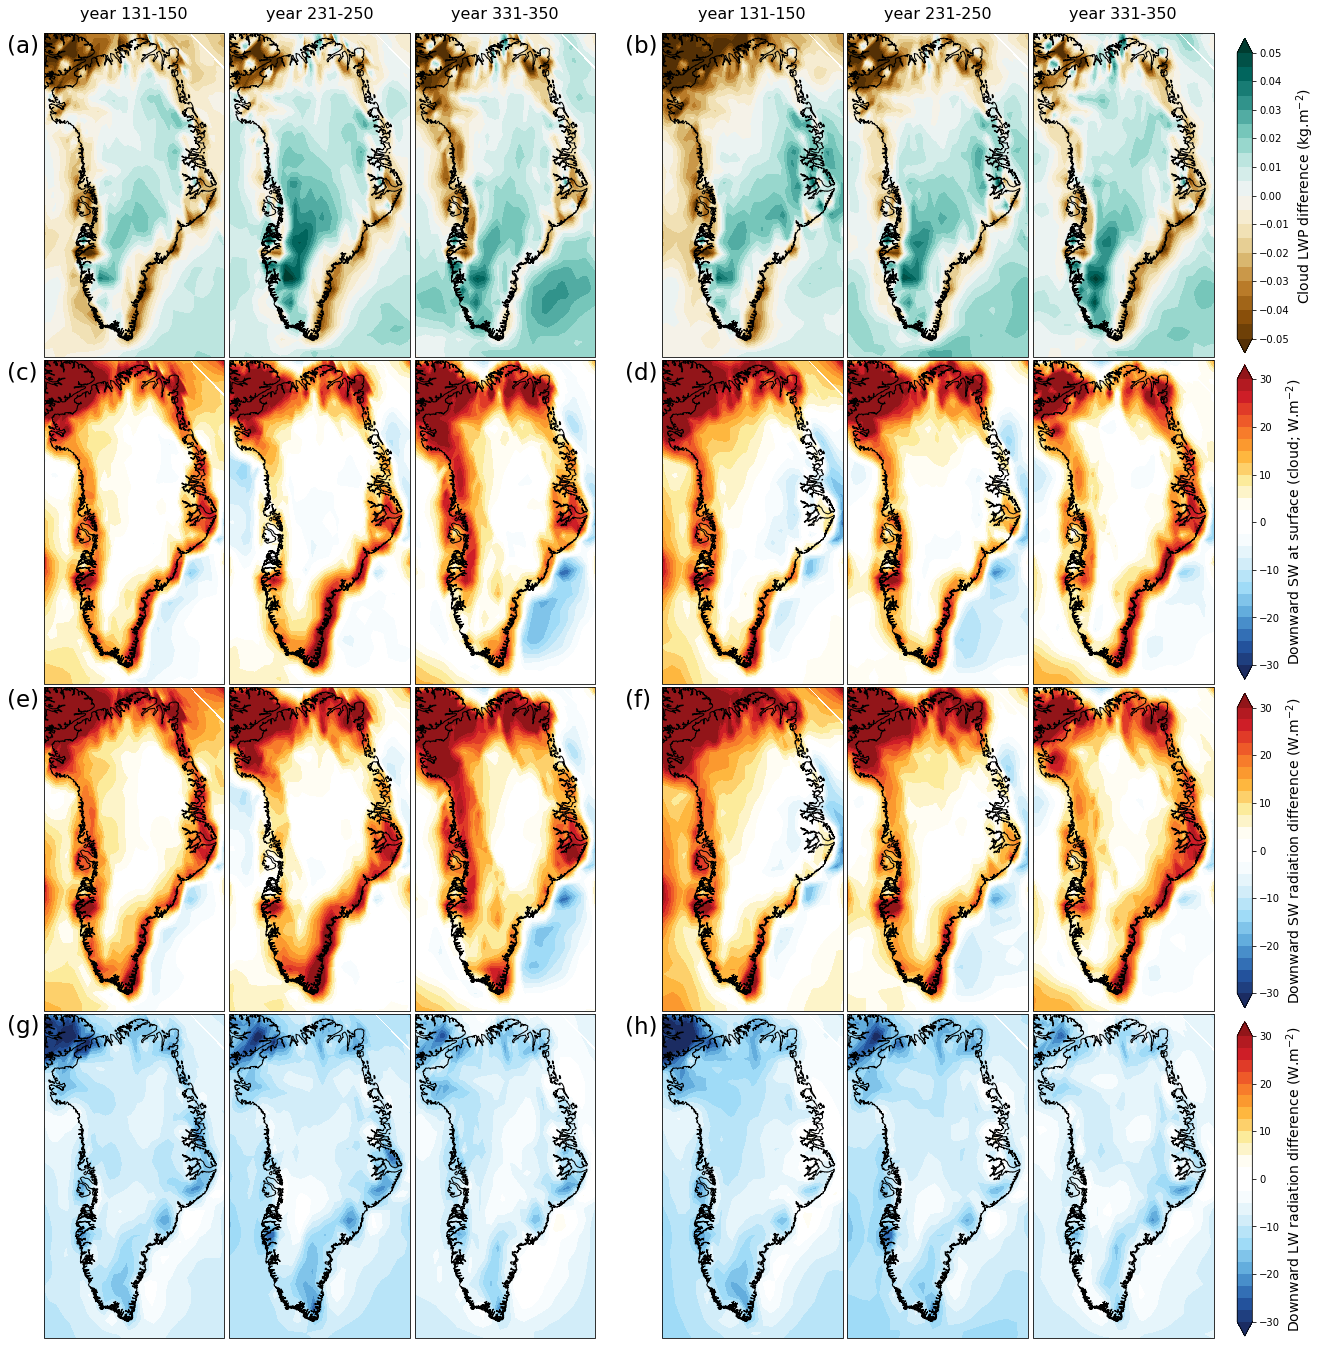

In [67]:
fig = plt.figure(figsize = (21,24))
gs=GridSpec(12,19)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.BrBG
bounds1 = np.arange(-0.05,0.051,0.005)
bounds1min = [-10]
bounds1max = [10]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-0.05,0.051,0.01)

cmap2 = cmaps.BlueWhiteOrangeRed
bounds2 = np.arange(-30.,30.1,2.5)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-30.,30.1,10.)

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0:3,0:3], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon, f09_lat, ARCTIC_f09_TGCLDLWP_diff_stab, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax1.text(-1000000, -800000, '(a)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax2 = plt.subplot(gs[0:3,3:6], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon, f09_lat, ARCTIC_f09_TGCLDLWP_diff_mid, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax3 = plt.subplot(gs[0:3,6:9], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon, f09_lat, ARCTIC_f09_TGCLDLWP_diff_end, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

ax4 = plt.subplot(gs[0:3,10:13], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_TGCLDLWP_diff_stab, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax4.text(-1000000, -800000, '(b)', fontsize=23)

ax5 = plt.subplot(gs[0:3,13:16], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_TGCLDLWP_diff_mid, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax6 = plt.subplot(gs[0:3,16:19], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_TGCLDLWP_diff_end, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.695, 0.01, 0.182])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb6.set_label(label='Cloud LWP difference (kg.$\mathregular{m^{-2}}$)', size=14)
cb6.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax7 = plt.subplot(gs[3:6,0:3], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.contourf(f09_lon, f09_lat, ARCTIC_f09_FSDScld_diff_stab, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-1000000, -800000, '(c)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax8 = plt.subplot(gs[3:6,3:6], projection=polar_stereographic)
ax8.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.contourf(f09_lon, f09_lat, ARCTIC_f09_FSDScld_diff_mid, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax9 = plt.subplot(gs[3:6,6:9], projection=polar_stereographic)
ax9.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax9.coastlines(resolution='10m', zorder=7)
im9 = ax9.contourf(f09_lon, f09_lat, ARCTIC_f09_FSDScld_diff_end, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax10 = plt.subplot(gs[3:6,10:13], projection=polar_stereographic)
ax10.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_stab, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-1000000, -800000, '(d)', fontsize=23)

ax11 = plt.subplot(gs[3:6,13:16], projection=polar_stereographic)
ax11.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_mid, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax12 = plt.subplot(gs[3:6,16:19], projection=polar_stereographic)
ax12.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax12.coastlines(resolution='10m', zorder=7)
im12 = ax12.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_end, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.506, 0.01, 0.182])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Downward SW at surface (cloud; W.$\mathregular{m^{-2}}$)', size=14)
cb12.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax13 = plt.subplot(gs[6:9,0:3], projection=polar_stereographic)
ax13.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax13.coastlines(resolution='10m', zorder=7)
im13 = ax13.contourf(f09_lon, f09_lat, ARCTIC_f09_FSDS_diff_stab, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(-1000000, -800000, '(e)', fontsize=23)

ax14 = plt.subplot(gs[6:9,3:6], projection=polar_stereographic)
ax14.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax14.coastlines(resolution='10m', zorder=7)
im14 = ax14.contourf(f09_lon, f09_lat, ARCTIC_f09_FSDS_diff_mid, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax15 = plt.subplot(gs[6:9,6:9], projection=polar_stereographic)
ax15.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax15.coastlines(resolution='10m', zorder=7)
im15 = ax15.contourf(f09_lon, f09_lat, ARCTIC_f09_FSDS_diff_end, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax16 = plt.subplot(gs[6:9,10:13], projection=polar_stereographic)
ax16.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax16.coastlines(resolution='10m', zorder=7)
im16 = ax16.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FSDS_diff_stab, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(-1000000, -800000, '(f)', fontsize=23)

ax17 = plt.subplot(gs[6:9,13:16], projection=polar_stereographic)
ax17.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax17.coastlines(resolution='10m', zorder=7)
im17 = ax17.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FSDS_diff_mid, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax17.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax17.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax18 = plt.subplot(gs[6:9,16:19], projection=polar_stereographic)
ax18.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax18.coastlines(resolution='10m', zorder=7)
im18 = ax18.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FSDS_diff_end, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax18.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax18.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax18 = fig.add_axes([0.915, 0.316, 0.01, 0.182])
cb18 = fig.colorbar(im18, cax=cbar_ax18, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb18.set_label(label='Downward SW radiation difference (W.$\mathregular{m^{-2}}$)', size=14)
cb18.ax.tick_params(labelsize=10)

#----------------------------line 4----------------------------
ax19 = plt.subplot(gs[9:12,0:3], projection=polar_stereographic)
ax19.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax19.coastlines(resolution='10m', zorder=7)
im19 = ax19.contourf(f09_lon, f09_lat, ARCTIC_f09_FLDS_diff_stab, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax19.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax19.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax19.text(-1000000, -800000, '(g)', fontsize=23)

ax20 = plt.subplot(gs[9:12,3:6], projection=polar_stereographic)
ax20.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax20.coastlines(resolution='10m', zorder=7)
im20 = ax20.contourf(f09_lon, f09_lat, ARCTIC_f09_FLDS_diff_mid, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax20.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax20.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax21 = plt.subplot(gs[9:12,6:9], projection=polar_stereographic)
ax21.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax21.coastlines(resolution='10m', zorder=7)
im21 = ax21.contourf(f09_lon, f09_lat, ARCTIC_f09_FLDS_diff_end, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax21.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax22 = plt.subplot(gs[9:12,10:13], projection=polar_stereographic)
ax22.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax22.coastlines(resolution='10m', zorder=7)
im22 = ax22.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FLDS_diff_stab, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax22.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax22.text(-1000000, -800000, '(h)', fontsize=23)

ax23 = plt.subplot(gs[9:12,13:16], projection=polar_stereographic)
ax23.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax23.coastlines(resolution='10m', zorder=7)
im23 = ax23.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FLDS_diff_mid, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax23.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax23.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax24 = plt.subplot(gs[9:12,16:19], projection=polar_stereographic)
ax24.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax24.coastlines(resolution='10m', zorder=7)
im24 = ax24.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_FLDS_diff_end, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax24.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax24.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax24 = fig.add_axes([0.915, 0.126, 0.01, 0.182])
cb24 = fig.colorbar(im24, cax=cbar_ax24, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb24.set_label(label='Downward LW radiation difference (W.$\mathregular{m^{-2}}$)', size=14)
cb24.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_LWP_SWdcld_SWd_LWdcld_LWd_diff.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

Paper: Cloud LWP, SWd, LWd due to clouds, LWd

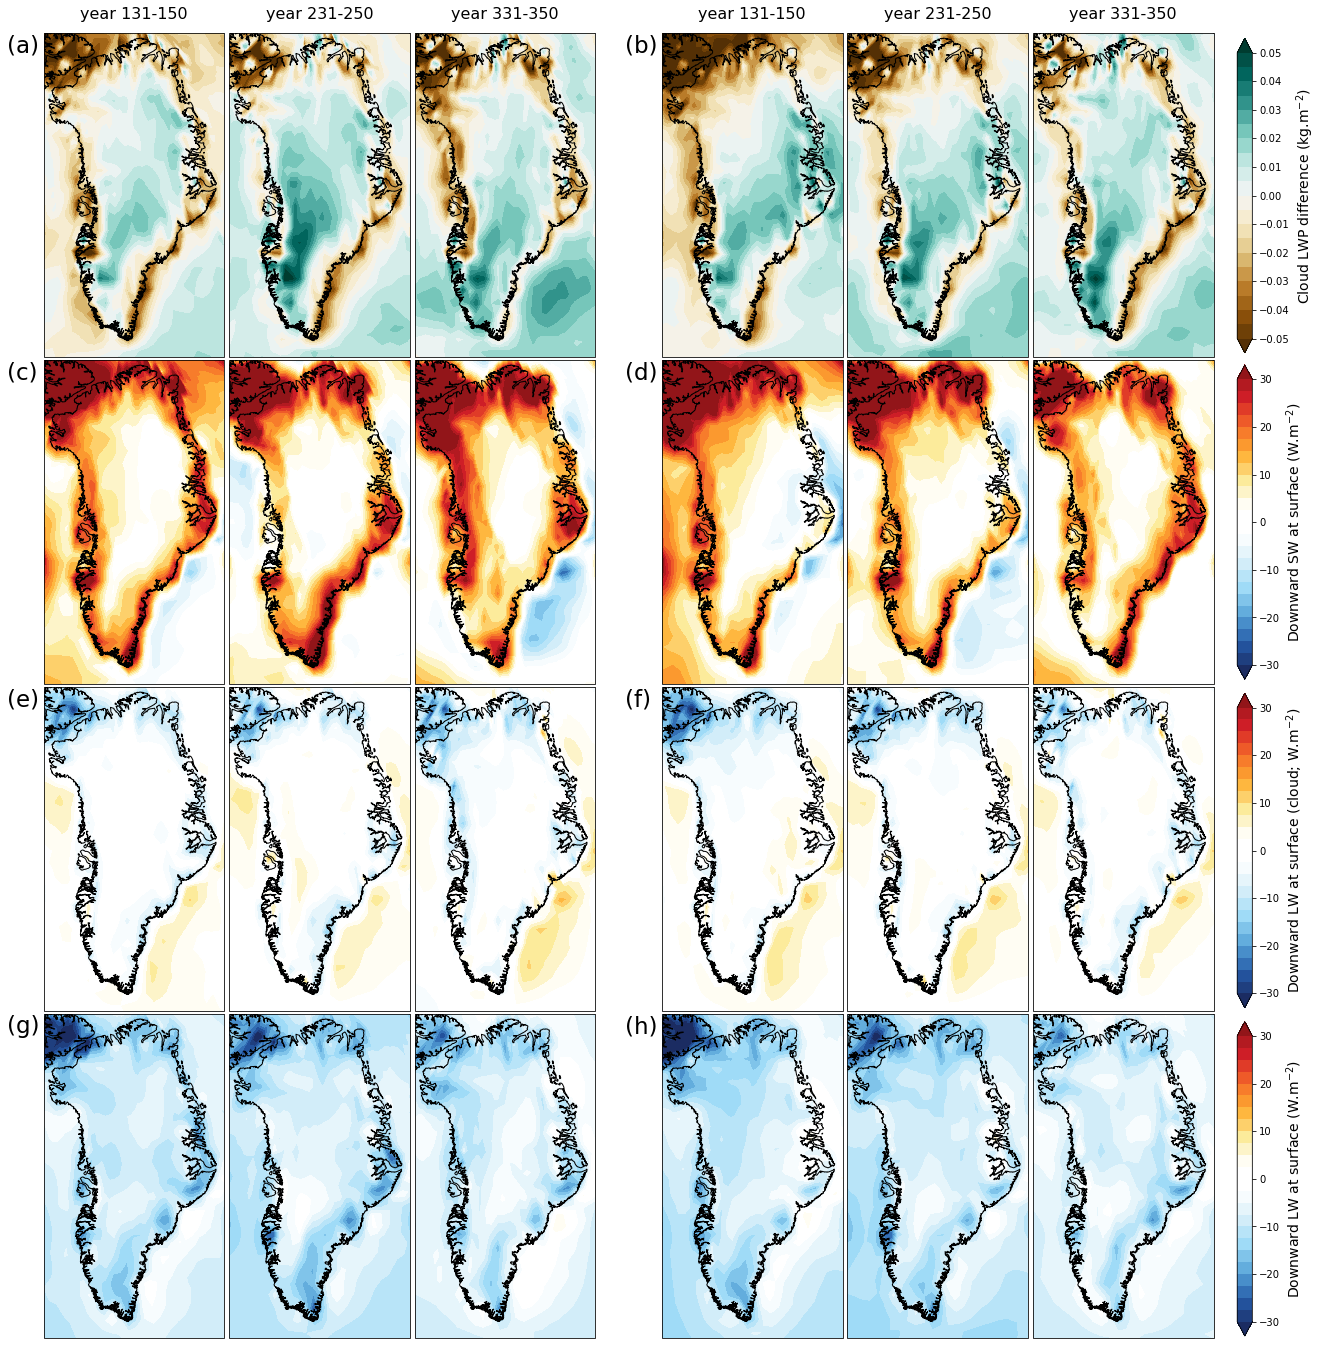

In [29]:
fig = plt.figure(figsize = (21,24))
gs=GridSpec(12,19)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.BrBG
bounds1 = np.arange(-0.05,0.051,0.005)
bounds1min = [-10]
bounds1max = [10]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-0.05,0.051,0.01)

cmap2 = cmaps.BlueWhiteOrangeRed
bounds2 = np.arange(-30.,30.1,2.5)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-30.,30.1,10.)

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0:3,0:3], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon2, f09_lat, ARCTIC_f09_TGCLDLWP_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax1.text(-1000000, -800000, '(a)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax2 = plt.subplot(gs[0:3,3:6], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon2, f09_lat, ARCTIC_f09_TGCLDLWP_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax3 = plt.subplot(gs[0:3,6:9], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon2, f09_lat, ARCTIC_f09_TGCLDLWP_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

ax4 = plt.subplot(gs[0:3,10:13], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_TGCLDLWP_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax4.text(-1000000, -800000, '(b)', fontsize=23)

ax5 = plt.subplot(gs[0:3,13:16], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_TGCLDLWP_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax6 = plt.subplot(gs[0:3,16:19], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_TGCLDLWP_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.695, 0.01, 0.182])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb6.set_label(label='Cloud LWP difference (kg.$\mathregular{m^{-2}}$)', size=14)
cb6.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax7 = plt.subplot(gs[3:6,0:3], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDS_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-1000000, -800000, '(c)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax8 = plt.subplot(gs[3:6,3:6], projection=polar_stereographic)
ax8.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDS_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax9 = plt.subplot(gs[3:6,6:9], projection=polar_stereographic)
ax9.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax9.coastlines(resolution='10m', zorder=7)
im9 = ax9.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDS_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax10 = plt.subplot(gs[3:6,10:13], projection=polar_stereographic)
ax10.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDS_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-1000000, -800000, '(d)', fontsize=23)

ax11 = plt.subplot(gs[3:6,13:16], projection=polar_stereographic)
ax11.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDS_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax12 = plt.subplot(gs[3:6,16:19], projection=polar_stereographic)
ax12.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax12.coastlines(resolution='10m', zorder=7)
im12 = ax12.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDS_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.506, 0.01, 0.182])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Downward SW at surface (W.$\mathregular{m^{-2}}$)', size=14)
cb12.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax13 = plt.subplot(gs[6:9,0:3], projection=polar_stereographic)
ax13.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax13.coastlines(resolution='10m', zorder=7)
im13 = ax13.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDScld_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(-1000000, -800000, '(e)', fontsize=23)

ax14 = plt.subplot(gs[6:9,3:6], projection=polar_stereographic)
ax14.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax14.coastlines(resolution='10m', zorder=7)
im14 = ax14.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDScld_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax15 = plt.subplot(gs[6:9,6:9], projection=polar_stereographic)
ax15.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax15.coastlines(resolution='10m', zorder=7)
im15 = ax15.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDScld_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax16 = plt.subplot(gs[6:9,10:13], projection=polar_stereographic)
ax16.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax16.coastlines(resolution='10m', zorder=7)
im16 = ax16.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDScld_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(-1000000, -800000, '(f)', fontsize=23)

ax17 = plt.subplot(gs[6:9,13:16], projection=polar_stereographic)
ax17.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax17.coastlines(resolution='10m', zorder=7)
im17 = ax17.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDScld_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax17.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax17.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax18 = plt.subplot(gs[6:9,16:19], projection=polar_stereographic)
ax18.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax18.coastlines(resolution='10m', zorder=7)
im18 = ax18.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDScld_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax18.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax18.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax18 = fig.add_axes([0.915, 0.316, 0.01, 0.182])
cb18 = fig.colorbar(im18, cax=cbar_ax18, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb18.set_label(label='Downward LW at surface (cloud; W.$\mathregular{m^{-2}}$)', size=14)
cb18.ax.tick_params(labelsize=10)

#----------------------------line 4----------------------------
ax19 = plt.subplot(gs[9:12,0:3], projection=polar_stereographic)
ax19.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax19.coastlines(resolution='10m', zorder=7)
im19 = ax19.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDS_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax19.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax19.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax19.text(-1000000, -800000, '(g)', fontsize=23)

ax20 = plt.subplot(gs[9:12,3:6], projection=polar_stereographic)
ax20.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax20.coastlines(resolution='10m', zorder=7)
im20 = ax20.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDS_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax20.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax20.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax21 = plt.subplot(gs[9:12,6:9], projection=polar_stereographic)
ax21.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax21.coastlines(resolution='10m', zorder=7)
im21 = ax21.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDS_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax21.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax22 = plt.subplot(gs[9:12,10:13], projection=polar_stereographic)
ax22.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax22.coastlines(resolution='10m', zorder=7)
im22 = ax22.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDS_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax22.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax22.text(-1000000, -800000, '(h)', fontsize=23)

ax23 = plt.subplot(gs[9:12,13:16], projection=polar_stereographic)
ax23.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax23.coastlines(resolution='10m', zorder=7)
im23 = ax23.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDS_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax23.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax23.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax24 = plt.subplot(gs[9:12,16:19], projection=polar_stereographic)
ax24.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax24.coastlines(resolution='10m', zorder=7)
im24 = ax24.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDS_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax24.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax24.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax24 = fig.add_axes([0.915, 0.126, 0.01, 0.182])
cb24 = fig.colorbar(im24, cax=cbar_ax24, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb24.set_label(label='Downward LW at surface (W.$\mathregular{m^{-2}}$)', size=14)
cb24.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_LWP_SWd_LWdcld_LWd_diff.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

Supplementary: Cloud fraction, SWd due to clouds, clear-sky, LWd clear-sky, albedo

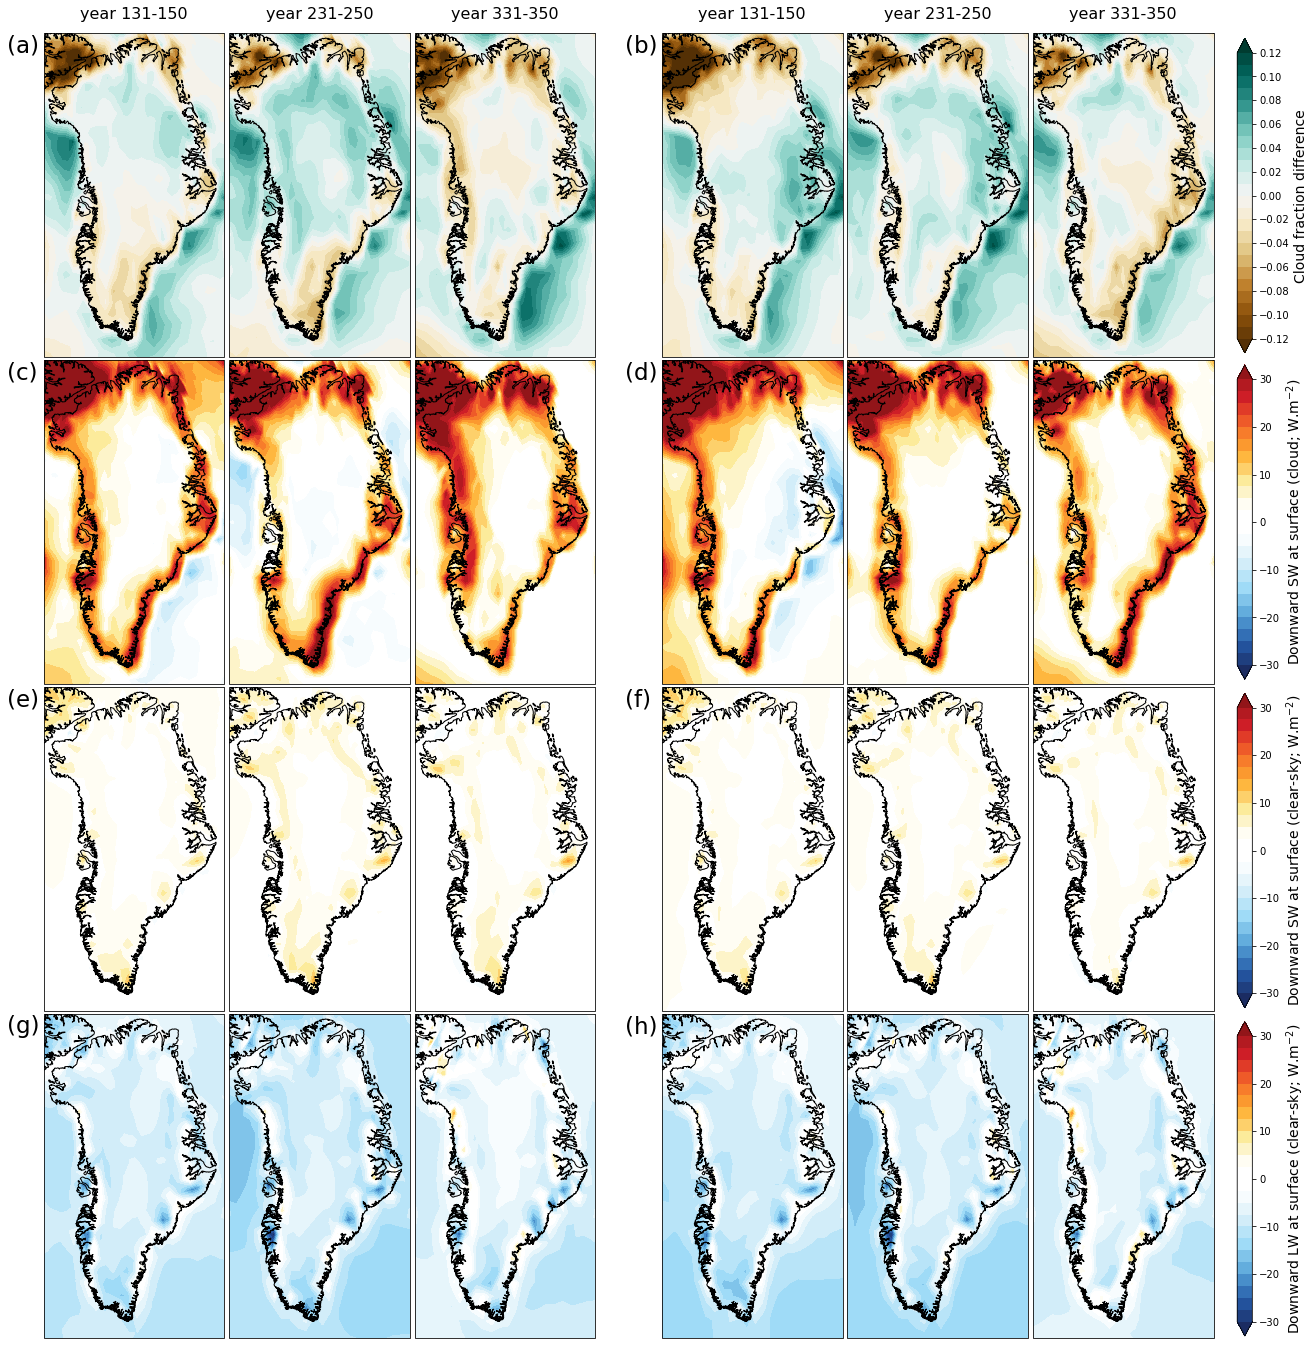

In [30]:
fig = plt.figure(figsize = (21,24))
gs=GridSpec(12,19)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.BrBG
bounds1 = np.arange(-0.12,0.121,0.01)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-0.12,0.121,0.02)

cmap2 = cmaps.BlueWhiteOrangeRed
bounds2 = np.arange(-30.,30.1,2.5)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-30.,30.1,10.)

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0:3,0:3], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax1.text(-1000000, -800000, '(a)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax2 = plt.subplot(gs[0:3,3:6], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax3 = plt.subplot(gs[0:3,6:9], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

ax4 = plt.subplot(gs[0:3,10:13], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax4.text(-1000000, -800000, '(b)', fontsize=23)

ax5 = plt.subplot(gs[0:3,13:16], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax6 = plt.subplot(gs[0:3,16:19], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.695, 0.01, 0.182])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb6.set_label(label='Cloud fraction difference', size=14)
cb6.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax7 = plt.subplot(gs[3:6,0:3], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDScld_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-1000000, -800000, '(c)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax8 = plt.subplot(gs[3:6,3:6], projection=polar_stereographic)
ax8.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDScld_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax9 = plt.subplot(gs[3:6,6:9], projection=polar_stereographic)
ax9.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax9.coastlines(resolution='10m', zorder=7)
im9 = ax9.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDScld_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax10 = plt.subplot(gs[3:6,10:13], projection=polar_stereographic)
ax10.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-1000000, -800000, '(d)', fontsize=23)

ax11 = plt.subplot(gs[3:6,13:16], projection=polar_stereographic)
ax11.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax12 = plt.subplot(gs[3:6,16:19], projection=polar_stereographic)
ax12.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax12.coastlines(resolution='10m', zorder=7)
im12 = ax12.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.506, 0.01, 0.182])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Downward SW at surface (cloud; W.$\mathregular{m^{-2}}$)', size=14)
cb12.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax13 = plt.subplot(gs[6:9,0:3], projection=polar_stereographic)
ax13.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax13.coastlines(resolution='10m', zorder=7)
im13 = ax13.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDSC_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(-1000000, -800000, '(e)', fontsize=23)

ax14 = plt.subplot(gs[6:9,3:6], projection=polar_stereographic)
ax14.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax14.coastlines(resolution='10m', zorder=7)
im14 = ax14.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDSC_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax15 = plt.subplot(gs[6:9,6:9], projection=polar_stereographic)
ax15.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax15.coastlines(resolution='10m', zorder=7)
im15 = ax15.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDSC_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax16 = plt.subplot(gs[6:9,10:13], projection=polar_stereographic)
ax16.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax16.coastlines(resolution='10m', zorder=7)
im16 = ax16.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDSC_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(-1000000, -800000, '(f)', fontsize=23)

ax17 = plt.subplot(gs[6:9,13:16], projection=polar_stereographic)
ax17.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax17.coastlines(resolution='10m', zorder=7)
im17 = ax17.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDSC_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax17.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax17.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax18 = plt.subplot(gs[6:9,16:19], projection=polar_stereographic)
ax18.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax18.coastlines(resolution='10m', zorder=7)
im18 = ax18.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDSC_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax18.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax18.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax18 = fig.add_axes([0.915, 0.316, 0.01, 0.182])
cb18 = fig.colorbar(im18, cax=cbar_ax18, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb18.set_label(label='Downward SW at surface (clear-sky; W.$\mathregular{m^{-2}}$)', size=14)
cb18.ax.tick_params(labelsize=10)

#----------------------------line 4----------------------------
ax19 = plt.subplot(gs[9:12,0:3], projection=polar_stereographic)
ax19.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax19.coastlines(resolution='10m', zorder=7)
im19 = ax19.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDSC_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax19.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax19.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax19.text(-1000000, -800000, '(g)', fontsize=23)

ax20 = plt.subplot(gs[9:12,3:6], projection=polar_stereographic)
ax20.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax20.coastlines(resolution='10m', zorder=7)
im20 = ax20.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDSC_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax20.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax20.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax21 = plt.subplot(gs[9:12,6:9], projection=polar_stereographic)
ax21.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax21.coastlines(resolution='10m', zorder=7)
im21 = ax21.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDSC_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax21.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax22 = plt.subplot(gs[9:12,10:13], projection=polar_stereographic)
ax22.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax22.coastlines(resolution='10m', zorder=7)
im22 = ax22.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDSC_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax22.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax22.text(-1000000, -800000, '(h)', fontsize=23)

ax23 = plt.subplot(gs[9:12,13:16], projection=polar_stereographic)
ax23.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax23.coastlines(resolution='10m', zorder=7)
im23 = ax23.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDSC_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax23.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax23.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax24 = plt.subplot(gs[9:12,16:19], projection=polar_stereographic)
ax24.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax24.coastlines(resolution='10m', zorder=7)
im24 = ax24.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDSC_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax24.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax24.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax24 = fig.add_axes([0.915, 0.126, 0.01, 0.182])
cb24 = fig.colorbar(im24, cax=cbar_ax24, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb24.set_label(label='Downward LW at surface (clear-sky; W.$\mathregular{m^{-2}}$)', size=14)
cb24.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_cldfrac_SWdcld_SWdcs_LWdcs_diff.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

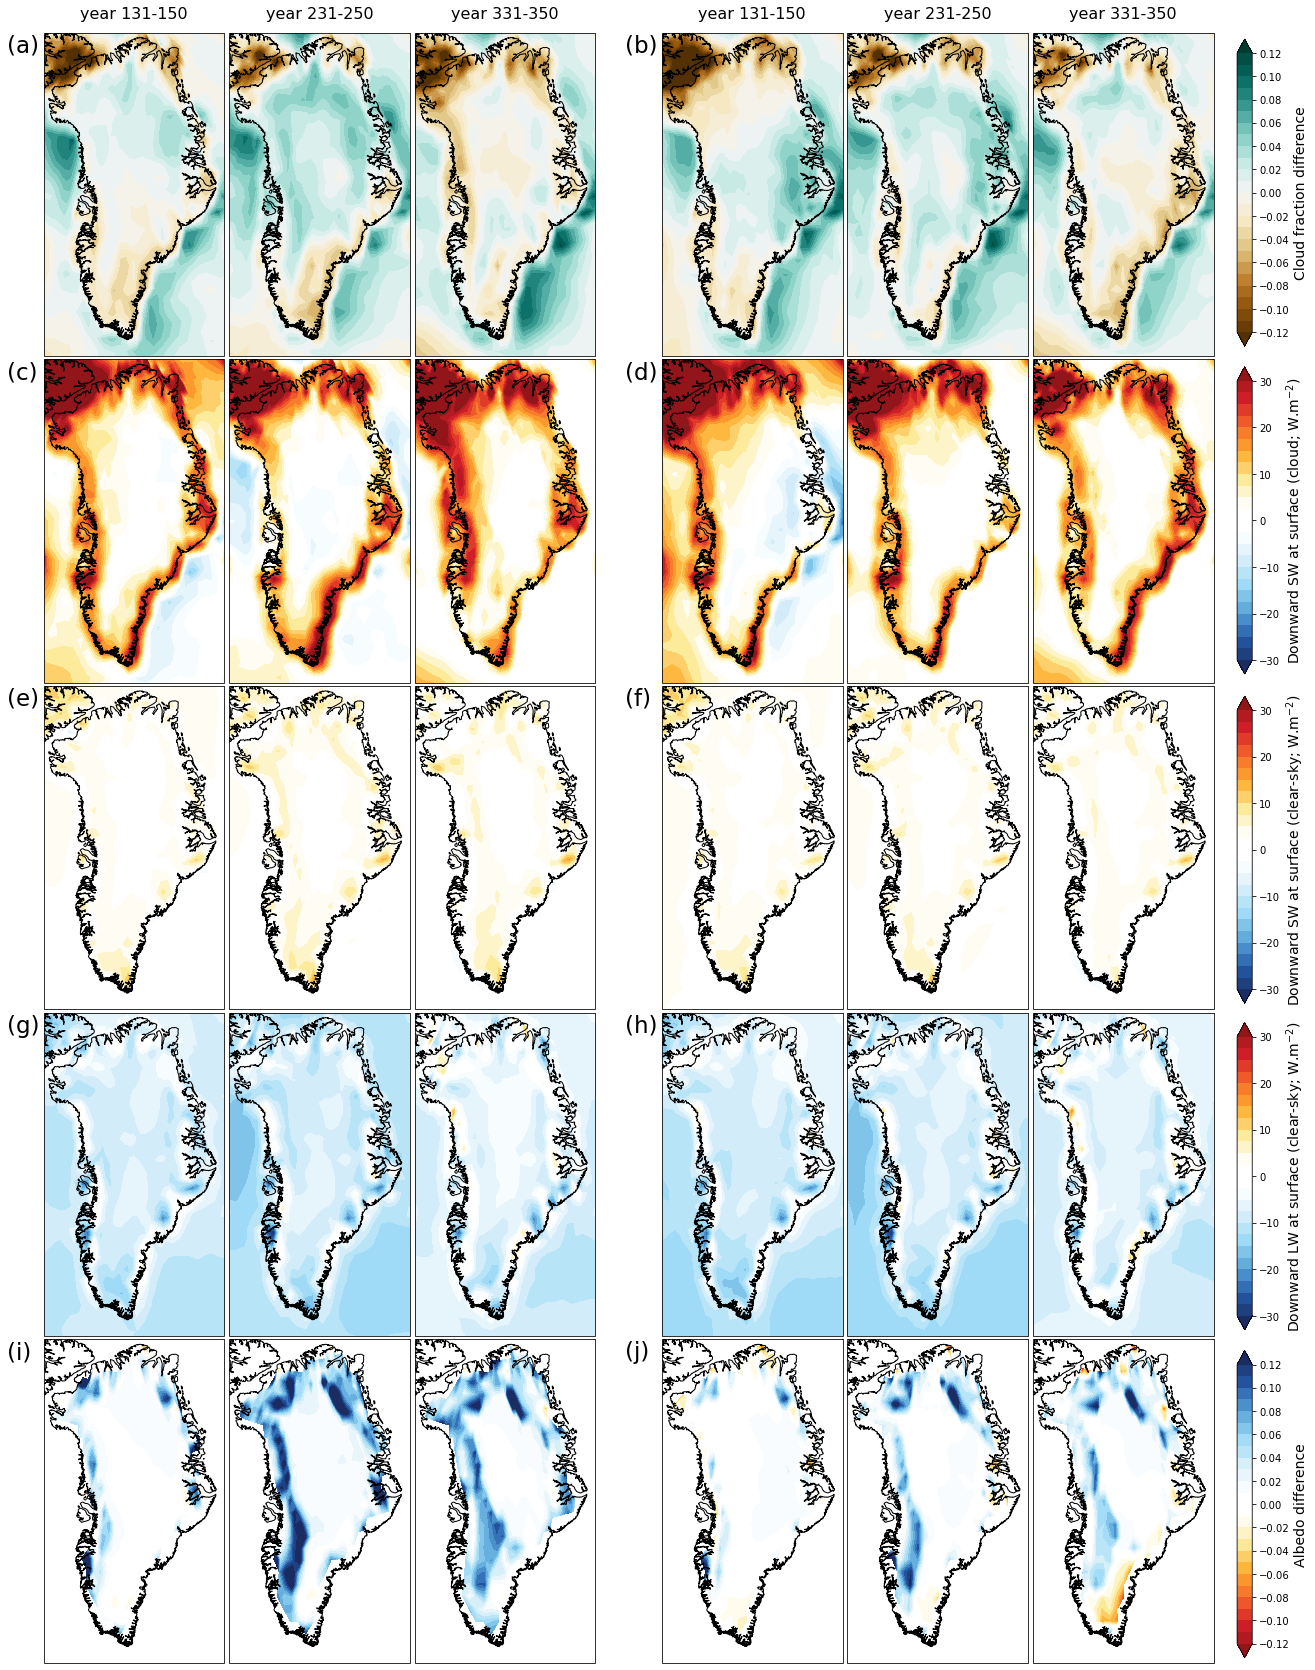

In [32]:
## Add albedo
fig = plt.figure(figsize = (21,36))
gs=GridSpec(18,19)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.BrBG
bounds1 = np.arange(-0.12,0.121,0.01)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-0.12,0.121,0.02)

cmap2 = cmaps.BlueWhiteOrangeRed
bounds2 = np.arange(-30.,30.1,2.5)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-30.,30.1,10.)

cmap3 = cmaps.BlueWhiteOrangeRed_r
bounds3 = np.arange(-0.12,0.121,0.01)
bounds3min = [-1]
bounds3max = [1]
norm3 = mpl.colors.BoundaryNorm(bounds3, cmap3.N, extend='both')
ticks3 = np.arange(-0.12,0.121,0.02)

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0:3,0:3], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax1.text(-1000000, -800000, '(a)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax2 = plt.subplot(gs[0:3,3:6], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax3 = plt.subplot(gs[0:3,6:9], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

ax4 = plt.subplot(gs[0:3,10:13], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax4.text(-1000000, -800000, '(b)', fontsize=23)

ax5 = plt.subplot(gs[0:3,13:16], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax6 = plt.subplot(gs[0:3,16:19], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.759, 0.01, 0.1185])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb6.set_label(label='Cloud fraction difference', size=14)
cb6.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax7 = plt.subplot(gs[3:6,0:3], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDScld_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-1000000, -800000, '(c)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax8 = plt.subplot(gs[3:6,3:6], projection=polar_stereographic)
ax8.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDScld_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax9 = plt.subplot(gs[3:6,6:9], projection=polar_stereographic)
ax9.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax9.coastlines(resolution='10m', zorder=7)
im9 = ax9.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDScld_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax10 = plt.subplot(gs[3:6,10:13], projection=polar_stereographic)
ax10.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-1000000, -800000, '(d)', fontsize=23)

ax11 = plt.subplot(gs[3:6,13:16], projection=polar_stereographic)
ax11.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax12 = plt.subplot(gs[3:6,16:19], projection=polar_stereographic)
ax12.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax12.coastlines(resolution='10m', zorder=7)
im12 = ax12.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDScld_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.6325, 0.01, 0.1185])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Downward SW at surface (cloud; W.$\mathregular{m^{-2}}$)', size=14)
cb12.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax13 = plt.subplot(gs[6:9,0:3], projection=polar_stereographic)
ax13.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax13.coastlines(resolution='10m', zorder=7)
im13 = ax13.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDSC_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(-1000000, -800000, '(e)', fontsize=23)

ax14 = plt.subplot(gs[6:9,3:6], projection=polar_stereographic)
ax14.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax14.coastlines(resolution='10m', zorder=7)
im14 = ax14.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDSC_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax15 = plt.subplot(gs[6:9,6:9], projection=polar_stereographic)
ax15.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax15.coastlines(resolution='10m', zorder=7)
im15 = ax15.contourf(f09_lon2, f09_lat, ARCTIC_f09_FSDSC_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax16 = plt.subplot(gs[6:9,10:13], projection=polar_stereographic)
ax16.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax16.coastlines(resolution='10m', zorder=7)
im16 = ax16.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDSC_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(-1000000, -800000, '(f)', fontsize=23)

ax17 = plt.subplot(gs[6:9,13:16], projection=polar_stereographic)
ax17.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax17.coastlines(resolution='10m', zorder=7)
im17 = ax17.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDSC_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax17.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax17.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax18 = plt.subplot(gs[6:9,16:19], projection=polar_stereographic)
ax18.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax18.coastlines(resolution='10m', zorder=7)
im18 = ax18.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FSDSC_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax18.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax18.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax18 = fig.add_axes([0.915, 0.5055, 0.01, 0.1185])
cb18 = fig.colorbar(im18, cax=cbar_ax18, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb18.set_label(label='Downward SW at surface (clear-sky; W.$\mathregular{m^{-2}}$)', size=14)
cb18.ax.tick_params(labelsize=10)

#----------------------------line 4----------------------------
ax19 = plt.subplot(gs[9:12,0:3], projection=polar_stereographic)
ax19.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax19.coastlines(resolution='10m', zorder=7)
im19 = ax19.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDSC_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax19.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax19.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax19.text(-1000000, -800000, '(g)', fontsize=23)

ax20 = plt.subplot(gs[9:12,3:6], projection=polar_stereographic)
ax20.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax20.coastlines(resolution='10m', zorder=7)
im20 = ax20.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDSC_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax20.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax20.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax21 = plt.subplot(gs[9:12,6:9], projection=polar_stereographic)
ax21.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax21.coastlines(resolution='10m', zorder=7)
im21 = ax21.contourf(f09_lon2, f09_lat, ARCTIC_f09_FLDSC_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax21.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax22 = plt.subplot(gs[9:12,10:13], projection=polar_stereographic)
ax22.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax22.coastlines(resolution='10m', zorder=7)
im22 = ax22.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDSC_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax22.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax22.text(-1000000, -800000, '(h)', fontsize=23)

ax23 = plt.subplot(gs[9:12,13:16], projection=polar_stereographic)
ax23.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax23.coastlines(resolution='10m', zorder=7)
im23 = ax23.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDSC_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax23.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax23.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax24 = plt.subplot(gs[9:12,16:19], projection=polar_stereographic)
ax24.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax24.coastlines(resolution='10m', zorder=7)
im24 = ax24.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_FLDSC_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax24.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax24.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax24 = fig.add_axes([0.915, 0.3795, 0.01, 0.1185])
cb24 = fig.colorbar(im24, cax=cbar_ax24, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb24.set_label(label='Downward LW at surface (clear-sky; W.$\mathregular{m^{-2}}$)', size=14)
cb24.ax.tick_params(labelsize=10)

#----------------------------line 5----------------------------
ax25 = plt.subplot(gs[12:15,0:3], projection=polar_stereographic)
ax25.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax25.coastlines(resolution='10m', zorder=7)
im25 = ax25.contourf(f09_lon, f09_lat, ARCTIC_f09_albedo_diff_stab, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax25.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax25.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax25.text(-1000000, -800000, '(i)', fontsize=23)

ax26 = plt.subplot(gs[12:15,3:6], projection=polar_stereographic)
ax26.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax26.coastlines(resolution='10m', zorder=7)
im26 = ax26.contourf(f09_lon, f09_lat, ARCTIC_f09_albedo_diff_mid, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax26.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax26.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax27 = plt.subplot(gs[12:15,6:9], projection=polar_stereographic)
ax27.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax27.coastlines(resolution='10m', zorder=7)
im27 = ax27.contourf(f09_lon, f09_lat, ARCTIC_f09_albedo_diff_end, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax27.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax27.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax28 = plt.subplot(gs[12:15,10:13], projection=polar_stereographic)
ax28.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax28.coastlines(resolution='10m', zorder=7)
im28 = ax28.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_albedo_diff_stab, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax28.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax28.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax28.text(-1000000, -800000, '(j)', fontsize=23)

ax29 = plt.subplot(gs[12:15,13:16], projection=polar_stereographic)
ax29.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax29.coastlines(resolution='10m', zorder=7)
im29= ax29.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_albedo_diff_mid, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax29.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax29.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax30 = plt.subplot(gs[12:15,16:19], projection=polar_stereographic)
ax30.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax30.coastlines(resolution='10m', zorder=7)
im30 = ax30.contourf(f09_lon, f09_lat, ARCTIC_f09_nohacks_albedo_diff_end, cmap=cmap3, norm=norm3, levels=bounds3, extend='both', transform=crs_ll)
ax30.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax30.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax30 = fig.add_axes([0.915, 0.253, 0.01, 0.1185])
cb30 = fig.colorbar(im30, cax=cbar_ax30, orientation='vertical', boundaries=bounds3min+bounds3+bounds3max, ticks=ticks3)
cb30.set_label(label='Albedo difference', size=14)
cb30.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_cldfrac_SWdcld_SWdcs_LWdcs_albedo_diff.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

### Test

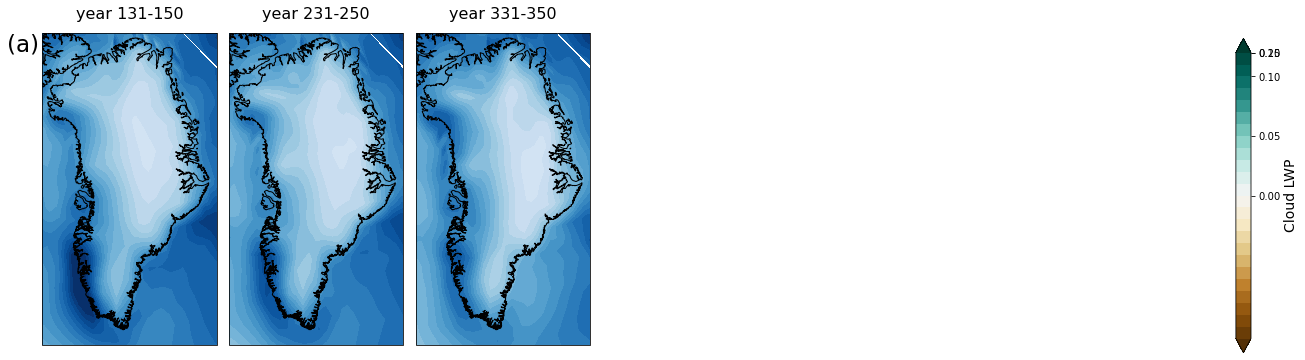

In [82]:
fig = plt.figure(figsize = (21,24))
gs=GridSpec(12,19)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.Blues
bounds1 = np.arange(0,0.201,0.01)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(0,0.201,0.05)

cmap2 = cmaps.BlueWhiteOrangeRed
bounds2 = np.arange(-30.,30.1,2.5)
bounds2min = [-1000]
bounds2max = [1000]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-30.,30.1,10.)

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0:3,0:3], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon, f09_lat, f09_TGCLDLWP_stab, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax1.text(-1000000, -800000, '(a)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax2 = plt.subplot(gs[0:3,3:6], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon, f09_lat, f09_TGCLDLWP_mid, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax3 = plt.subplot(gs[0:3,6:9], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon, f09_lat, f09_TGCLDLWP_end, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.695, 0.01, 0.182])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb6.set_label(label='Cloud LWP', size=14)
cb6.ax.tick_params(labelsize=10)

Text(0.5, 1.0, 'year 131-150')

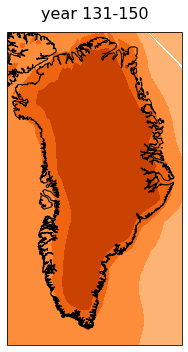

In [84]:
fig = plt.figure(figsize = (21,24))
gs=GridSpec(12,19)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0:3,0:3], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon, f09_lat, f09_FSDS_stab, transform=crs_ll, cmap=plt.cm.Oranges)#, norm=norm1, levels=bounds1, extend='both')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
#ax1.text(-1000000, -800000, '(a)', fontsize=23)
#f09_TGCLDLWP_stab.plot();

## 4. JJA mean cloud fraction difference at different levels <a class="anchor" id="first-bullet"></a>

### Read data

In [88]:
# f09nohacks
data_dir = '/glade/derecho/scratch/ziqiyin/2022-VR-dynamic-GrIS/'

# 1pctCO2
f09_nohacks_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_nohacks_1pctCO2_CLDLOW_JJA = xr.open_dataset(data_dir+'f09_nohacks_CLDLOW_atm_1pctCO2_JJA_yearly.nc')['CLDLOW']
f09_nohacks_1pctCO2_CLDMED_JJA = xr.open_dataset(data_dir+'f09_nohacks_CLDMED_atm_1pctCO2_JJA_yearly.nc')['CLDMED']
f09_nohacks_1pctCO2_CLDHGH_JJA = xr.open_dataset(data_dir+'f09_nohacks_CLDHGH_atm_1pctCO2_JJA_yearly.nc')['CLDHGH']
f09_lon = f09_nohacks_1pctCO2_CLDTOT_JJA.lon
f09_lat = f09_nohacks_1pctCO2_CLDTOT_JJA.lat

# 4xext
f09_nohacks_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_nohacks_4xext_CLDLOW_JJA = xr.open_dataset(data_dir+'f09_nohacks_CLDLOW_atm_4xext_JJA_yearly.nc')['CLDLOW']
f09_nohacks_4xext_CLDMED_JJA = xr.open_dataset(data_dir+'f09_nohacks_CLDMED_atm_4xext_JJA_yearly.nc')['CLDMED']
f09_nohacks_4xext_CLDHGH_JJA = xr.open_dataset(data_dir+'f09_nohacks_CLDHGH_atm_4xext_JJA_yearly.nc')['CLDHGH']

In [89]:
# f09muntjewerf
# 1pctCO2
f09_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'][:140,:,:] #[fraction]
f09_1pctCO2_CLDLOW_JJA = xr.open_dataset(data_dir+'f09_CLDLOW_atm_1pctCO2_JJA_yearly.nc')['CLDLOW']
f09_1pctCO2_CLDMED_JJA = xr.open_dataset(data_dir+'f09_CLDMED_atm_1pctCO2_JJA_yearly.nc')['CLDMED']
f09_1pctCO2_CLDHGH_JJA = xr.open_dataset(data_dir+'f09_CLDHGH_atm_1pctCO2_JJA_yearly.nc')['CLDHGH']

# 4xext
f09_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
f09_4xext_CLDLOW_JJA = xr.open_dataset(data_dir+'f09_CLDLOW_atm_4xext_JJA_yearly.nc')['CLDLOW']
f09_4xext_CLDMED_JJA = xr.open_dataset(data_dir+'f09_CLDMED_atm_4xext_JJA_yearly.nc')['CLDMED']
f09_4xext_CLDHGH_JJA = xr.open_dataset(data_dir+'f09_CLDHGH_atm_4xext_JJA_yearly.nc')['CLDHGH']

In [90]:
# arctic
# 1pctCO2
ARCTIC_1pctCO2_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_CLDTOT_1pctCO2_JJA_yearly.nc')['CLDTOT'] #[fraction]
ARCTIC_1pctCO2_CLDLOW_JJA = xr.open_dataset(data_dir+'ARCTIC_CLDLOW_atm_1pctCO2_JJA_yearly.nc')['CLDLOW']
ARCTIC_1pctCO2_CLDMED_JJA = xr.open_dataset(data_dir+'ARCTIC_CLDMED_atm_1pctCO2_JJA_yearly.nc')['CLDMED']
ARCTIC_1pctCO2_CLDHGH_JJA = xr.open_dataset(data_dir+'ARCTIC_CLDHGH_atm_1pctCO2_JJA_yearly.nc')['CLDHGH']

# 4xext
ARCTIC_4xext_CLDTOT_JJA = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_CLDTOT_4xext_JJA_yearly.nc')['CLDTOT'] #[fraction]
ARCTIC_4xext_CLDLOW_JJA = xr.open_dataset(data_dir+'ARCTIC_CLDLOW_atm_4xext_JJA_yearly.nc')['CLDLOW']
ARCTIC_4xext_CLDMED_JJA = xr.open_dataset(data_dir+'ARCTIC_CLDMED_atm_4xext_JJA_yearly.nc')['CLDMED']
ARCTIC_4xext_CLDHGH_JJA = xr.open_dataset(data_dir+'ARCTIC_CLDHGH_atm_4xext_JJA_yearly.nc')['CLDHGH']

In [91]:
f09_nohacks_1pctCO2_4xext_CLDTOT_JJA = xr.concat([f09_nohacks_1pctCO2_CLDTOT_JJA, f09_nohacks_4xext_CLDTOT_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_CLDLOW_JJA = xr.concat([f09_nohacks_1pctCO2_CLDLOW_JJA, f09_nohacks_4xext_CLDLOW_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_CLDMED_JJA = xr.concat([f09_nohacks_1pctCO2_CLDMED_JJA, f09_nohacks_4xext_CLDMED_JJA], dim='time')
f09_nohacks_1pctCO2_4xext_CLDHGH_JJA = xr.concat([f09_nohacks_1pctCO2_CLDHGH_JJA, f09_nohacks_4xext_CLDHGH_JJA], dim='time')

f09_1pctCO2_4xext_CLDTOT_JJA = xr.concat([f09_1pctCO2_CLDTOT_JJA, f09_4xext_CLDTOT_JJA], dim='time')
f09_1pctCO2_4xext_CLDLOW_JJA = xr.concat([f09_1pctCO2_CLDLOW_JJA, f09_4xext_CLDLOW_JJA], dim='time')
f09_1pctCO2_4xext_CLDMED_JJA = xr.concat([f09_1pctCO2_CLDMED_JJA, f09_4xext_CLDMED_JJA], dim='time')
f09_1pctCO2_4xext_CLDHGH_JJA = xr.concat([f09_1pctCO2_CLDHGH_JJA, f09_4xext_CLDHGH_JJA], dim='time')

ARCTIC_1pctCO2_4xext_CLDTOT_JJA = xr.concat([ARCTIC_1pctCO2_CLDTOT_JJA, ARCTIC_4xext_CLDTOT_JJA], dim='time')
ARCTIC_1pctCO2_4xext_CLDLOW_JJA = xr.concat([ARCTIC_1pctCO2_CLDLOW_JJA, ARCTIC_4xext_CLDLOW_JJA], dim='time')
ARCTIC_1pctCO2_4xext_CLDMED_JJA = xr.concat([ARCTIC_1pctCO2_CLDMED_JJA, ARCTIC_4xext_CLDMED_JJA], dim='time')
ARCTIC_1pctCO2_4xext_CLDHGH_JJA = xr.concat([ARCTIC_1pctCO2_CLDHGH_JJA, ARCTIC_4xext_CLDHGH_JJA], dim='time')

In [92]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

### Select

In [93]:
f09_nohacks_CLDTOT_stab = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_CLDLOW_stab = f09_nohacks_1pctCO2_4xext_CLDLOW_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_CLDMED_stab = f09_nohacks_1pctCO2_4xext_CLDMED_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_CLDHGH_stab = f09_nohacks_1pctCO2_4xext_CLDHGH_JJA[130:150,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_stab = np.mean(f09_nohacks_GrIS_mask[130:150,:,:], axis=0)

f09_CLDTOT_stab = f09_1pctCO2_4xext_CLDTOT_JJA[130:150,:,:].mean(dim='time')
f09_CLDLOW_stab = f09_1pctCO2_4xext_CLDLOW_JJA[130:150,:,:].mean(dim='time')
f09_CLDMED_stab = f09_1pctCO2_4xext_CLDMED_JJA[130:150,:,:].mean(dim='time')
f09_CLDHGH_stab = f09_1pctCO2_4xext_CLDHGH_JJA[130:150,:,:].mean(dim='time')
f09_GrIS_mask_stab = np.mean(f09_GrIS_mask[130:150,:,:], axis=0)

ARCTIC_CLDTOT_stab = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[130:150,:].mean(dim='time')
ARCTIC_CLDLOW_stab = ARCTIC_1pctCO2_4xext_CLDLOW_JJA[130:150,:].mean(dim='time')
ARCTIC_CLDMED_stab = ARCTIC_1pctCO2_4xext_CLDMED_JJA[130:150,:].mean(dim='time')
ARCTIC_CLDHGH_stab = ARCTIC_1pctCO2_4xext_CLDHGH_JJA[130:150,:].mean(dim='time')
ARCTIC_GrIS_mask_stab = np.mean(ARCTIC_GrIS_mask[130:150,:], axis=0)

In [94]:
f09_nohacks_CLDTOT_mid = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_CLDLOW_mid = f09_nohacks_1pctCO2_4xext_CLDLOW_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_CLDMED_mid = f09_nohacks_1pctCO2_4xext_CLDMED_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_CLDHGH_mid = f09_nohacks_1pctCO2_4xext_CLDHGH_JJA[230:250,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_mid = np.mean(f09_nohacks_GrIS_mask[230:250,:,:], axis=0)

f09_CLDTOT_mid = f09_1pctCO2_4xext_CLDTOT_JJA[230:250,:,:].mean(dim='time')
f09_CLDLOW_mid = f09_1pctCO2_4xext_CLDLOW_JJA[230:250,:,:].mean(dim='time')
f09_CLDMED_mid = f09_1pctCO2_4xext_CLDMED_JJA[230:250,:,:].mean(dim='time')
f09_CLDHGH_mid = f09_1pctCO2_4xext_CLDHGH_JJA[230:250,:,:].mean(dim='time')
f09_GrIS_mask_mid = np.mean(f09_GrIS_mask[230:250,:,:], axis=0)

ARCTIC_CLDTOT_mid = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[230:250,:].mean(dim='time')
ARCTIC_CLDLOW_mid = ARCTIC_1pctCO2_4xext_CLDLOW_JJA[230:250,:].mean(dim='time')
ARCTIC_CLDMED_mid = ARCTIC_1pctCO2_4xext_CLDMED_JJA[230:250,:].mean(dim='time')
ARCTIC_CLDHGH_mid = ARCTIC_1pctCO2_4xext_CLDHGH_JJA[230:250,:].mean(dim='time')
ARCTIC_GrIS_mask_mid = np.mean(ARCTIC_GrIS_mask[230:250,:], axis=0)

In [95]:
f09_nohacks_CLDTOT_end = f09_nohacks_1pctCO2_4xext_CLDTOT_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_CLDLOW_end = f09_nohacks_1pctCO2_4xext_CLDLOW_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_CLDMED_end = f09_nohacks_1pctCO2_4xext_CLDMED_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_CLDHGH_end = f09_nohacks_1pctCO2_4xext_CLDHGH_JJA[-20:,:,:].mean(dim='time')
f09_nohacks_GrIS_mask_end = np.mean(f09_nohacks_GrIS_mask[-20:,:,:], axis=0)

f09_CLDTOT_end = f09_1pctCO2_4xext_CLDTOT_JJA[-20:,:,:].mean(dim='time')
f09_CLDLOW_end = f09_1pctCO2_4xext_CLDLOW_JJA[-20:,:,:].mean(dim='time')
f09_CLDMED_end = f09_1pctCO2_4xext_CLDMED_JJA[-20:,:,:].mean(dim='time')
f09_CLDHGH_end = f09_1pctCO2_4xext_CLDHGH_JJA[-20:,:,:].mean(dim='time')
f09_GrIS_mask_end = np.mean(f09_GrIS_mask[-20:,:,:], axis=0)

ARCTIC_CLDTOT_end = ARCTIC_1pctCO2_4xext_CLDTOT_JJA[-20:,:].mean(dim='time')
ARCTIC_CLDLOW_end = ARCTIC_1pctCO2_4xext_CLDLOW_JJA[-20:,:].mean(dim='time')
ARCTIC_CLDMED_end = ARCTIC_1pctCO2_4xext_CLDMED_JJA[-20:,:].mean(dim='time')
ARCTIC_CLDHGH_end = ARCTIC_1pctCO2_4xext_CLDHGH_JJA[-20:,:].mean(dim='time')
ARCTIC_GrIS_mask_end = np.mean(ARCTIC_GrIS_mask[-20:,:], axis=0)

### Regrid ARCTIC to f09

In [96]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [97]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [98]:
ESMF.Manager(debug=True);

In [99]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [100]:
ARCTIC2f09_CLDTOT_stab = f09_CLDTOT_stab * 0
ARCTIC2f09_GrIS_mask_stab = f09_GrIS_mask_stab * 0

ARCTIC2f09_CLDTOT_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_stab, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_stab, f09_centers, f09_corners)

In [101]:
ARCTIC2f09_CLDTOT_mid = f09_CLDTOT_mid * 0
ARCTIC2f09_GrIS_mask_mid = f09_GrIS_mask_mid * 0

ARCTIC2f09_CLDTOT_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_mid, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_mid, f09_centers, f09_corners)

In [102]:
ARCTIC2f09_CLDTOT_end = f09_CLDTOT_end * 0
ARCTIC2f09_GrIS_mask_end = f09_GrIS_mask_end * 0

ARCTIC2f09_CLDTOT_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_CLDTOT_end, f09_centers, f09_corners)
ARCTIC2f09_GrIS_mask_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_GrIS_mask_end, f09_centers, f09_corners)

#### Only if use mask

In [17]:
# stab
f09_FSDS_stab = f09_FSDS_stab.where(f09_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)
f09_FLDS_stab = f09_FLDS_stab.where(f09_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)

f09_nohacks_FSDS_stab = f09_nohacks_FSDS_stab.where(f09_nohacks_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)
f09_nohacks_FLDS_stab = f09_nohacks_FLDS_stab.where(f09_nohacks_GrIS_mask_stab>0).where(ARCTIC2f09_GrIS_mask_stab>0)

# mid
f09_FSDS_mid = f09_FSDS_mid.where(f09_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)
f09_FLDS_mid = f09_FLDS_mid.where(f09_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)

f09_nohacks_FSDS_mid = f09_nohacks_FSDS_mid.where(f09_nohacks_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)
f09_nohacks_FLDS_mid = f09_nohacks_FLDS_mid.where(f09_nohacks_GrIS_mask_mid>0).where(ARCTIC2f09_GrIS_mask_mid>0)

# end
f09_FSDS_end = f09_FSDS_end.where(f09_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)
f09_FLDS_end = f09_FLDS_end.where(f09_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)

f09_nohacks_FSDS_end = f09_nohacks_FSDS_end.where(f09_nohacks_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)
f09_nohacks_FLDS_end = f09_nohacks_FLDS_end.where(f09_nohacks_GrIS_mask_end>0).where(ARCTIC2f09_GrIS_mask_end>0)

### Calculate

#### year 131-150

In [103]:
## Calculate difference
ARCTIC_f09_CLDTOT_diff_stab = ARCTIC2f09_CLDTOT_stab - f09_CLDTOT_stab
ARCTIC_f09_nohacks_CLDTOT_diff_stab = ARCTIC2f09_CLDTOT_stab - f09_nohacks_CLDTOT_stab
ARCTIC_f09_CLDLOW_diff_stab = ARCTIC_CLDLOW_stab.values - f09_CLDLOW_stab.values
ARCTIC_f09_nohacks_CLDLOW_diff_stab = ARCTIC_CLDLOW_stab.values - f09_nohacks_CLDLOW_stab.values
ARCTIC_f09_CLDMED_diff_stab = ARCTIC_CLDMED_stab.values - f09_CLDMED_stab.values
ARCTIC_f09_nohacks_CLDMED_diff_stab = ARCTIC_CLDMED_stab.values - f09_nohacks_CLDMED_stab.values
ARCTIC_f09_CLDHGH_diff_stab = ARCTIC_CLDHGH_stab.values - f09_CLDHGH_stab.values
ARCTIC_f09_nohacks_CLDHGH_diff_stab = ARCTIC_CLDHGH_stab.values - f09_nohacks_CLDHGH_stab.values

In [104]:
## Add cyclic points
ARCTIC_f09_CLDTOT_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDTOT_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_CLDTOT_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDTOT_diff_stab, coord=f09_lon)
ARCTIC_f09_CLDLOW_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDLOW_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_CLDLOW_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDLOW_diff_stab, coord=f09_lon)
ARCTIC_f09_CLDMED_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDMED_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_CLDMED_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDMED_diff_stab, coord=f09_lon)
ARCTIC_f09_CLDHGH_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDHGH_diff_stab, coord=f09_lon)
ARCTIC_f09_nohacks_CLDHGH_diff_stab2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDHGH_diff_stab, coord=f09_lon)

#### year 231-250

In [105]:
## Calculate difference
ARCTIC_f09_CLDTOT_diff_mid = ARCTIC2f09_CLDTOT_mid - f09_CLDTOT_mid
ARCTIC_f09_nohacks_CLDTOT_diff_mid = ARCTIC2f09_CLDTOT_mid - f09_nohacks_CLDTOT_mid
ARCTIC_f09_CLDLOW_diff_mid = ARCTIC_CLDLOW_mid.values - f09_CLDLOW_mid.values
ARCTIC_f09_nohacks_CLDLOW_diff_mid = ARCTIC_CLDLOW_mid.values - f09_nohacks_CLDLOW_mid.values
ARCTIC_f09_CLDMED_diff_mid = ARCTIC_CLDMED_mid.values - f09_CLDMED_mid.values
ARCTIC_f09_nohacks_CLDMED_diff_mid = ARCTIC_CLDMED_mid.values - f09_nohacks_CLDMED_mid.values
ARCTIC_f09_CLDHGH_diff_mid = ARCTIC_CLDHGH_mid.values - f09_CLDHGH_mid.values
ARCTIC_f09_nohacks_CLDHGH_diff_mid = ARCTIC_CLDHGH_mid.values - f09_nohacks_CLDHGH_mid.values

In [106]:
## Add cyclic points
ARCTIC_f09_CLDTOT_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDTOT_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_CLDTOT_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDTOT_diff_mid, coord=f09_lon)
ARCTIC_f09_CLDLOW_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDLOW_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_CLDLOW_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDLOW_diff_mid, coord=f09_lon)
ARCTIC_f09_CLDMED_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDMED_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_CLDMED_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDMED_diff_mid, coord=f09_lon)
ARCTIC_f09_CLDHGH_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDHGH_diff_mid, coord=f09_lon)
ARCTIC_f09_nohacks_CLDHGH_diff_mid2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDHGH_diff_mid, coord=f09_lon)

#### year 331-350

In [107]:
## Calculate difference
ARCTIC_f09_CLDTOT_diff_end = ARCTIC2f09_CLDTOT_end - f09_CLDTOT_end
ARCTIC_f09_nohacks_CLDTOT_diff_end = ARCTIC2f09_CLDTOT_end - f09_nohacks_CLDTOT_end
ARCTIC_f09_CLDLOW_diff_end = ARCTIC_CLDLOW_end.values - f09_CLDLOW_end.values
ARCTIC_f09_nohacks_CLDLOW_diff_end = ARCTIC_CLDLOW_end.values - f09_nohacks_CLDLOW_end.values
ARCTIC_f09_CLDMED_diff_end = ARCTIC_CLDMED_end.values - f09_CLDMED_end.values
ARCTIC_f09_nohacks_CLDMED_diff_end = ARCTIC_CLDMED_end.values - f09_nohacks_CLDMED_end.values
ARCTIC_f09_CLDHGH_diff_end = ARCTIC_CLDHGH_end.values - f09_CLDHGH_end.values
ARCTIC_f09_nohacks_CLDHGH_diff_end = ARCTIC_CLDHGH_end.values - f09_nohacks_CLDHGH_end.values

In [108]:
## Add cyclic points
ARCTIC_f09_CLDTOT_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDTOT_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_CLDTOT_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDTOT_diff_end, coord=f09_lon)
ARCTIC_f09_CLDLOW_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDLOW_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_CLDLOW_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDLOW_diff_end, coord=f09_lon)
ARCTIC_f09_CLDMED_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDMED_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_CLDMED_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDMED_diff_end, coord=f09_lon)
ARCTIC_f09_CLDHGH_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_CLDHGH_diff_end, coord=f09_lon)
ARCTIC_f09_nohacks_CLDHGH_diff_end2, f09_lon2 = add_cyclic_point(ARCTIC_f09_nohacks_CLDHGH_diff_end, coord=f09_lon)

### Plot

In [109]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

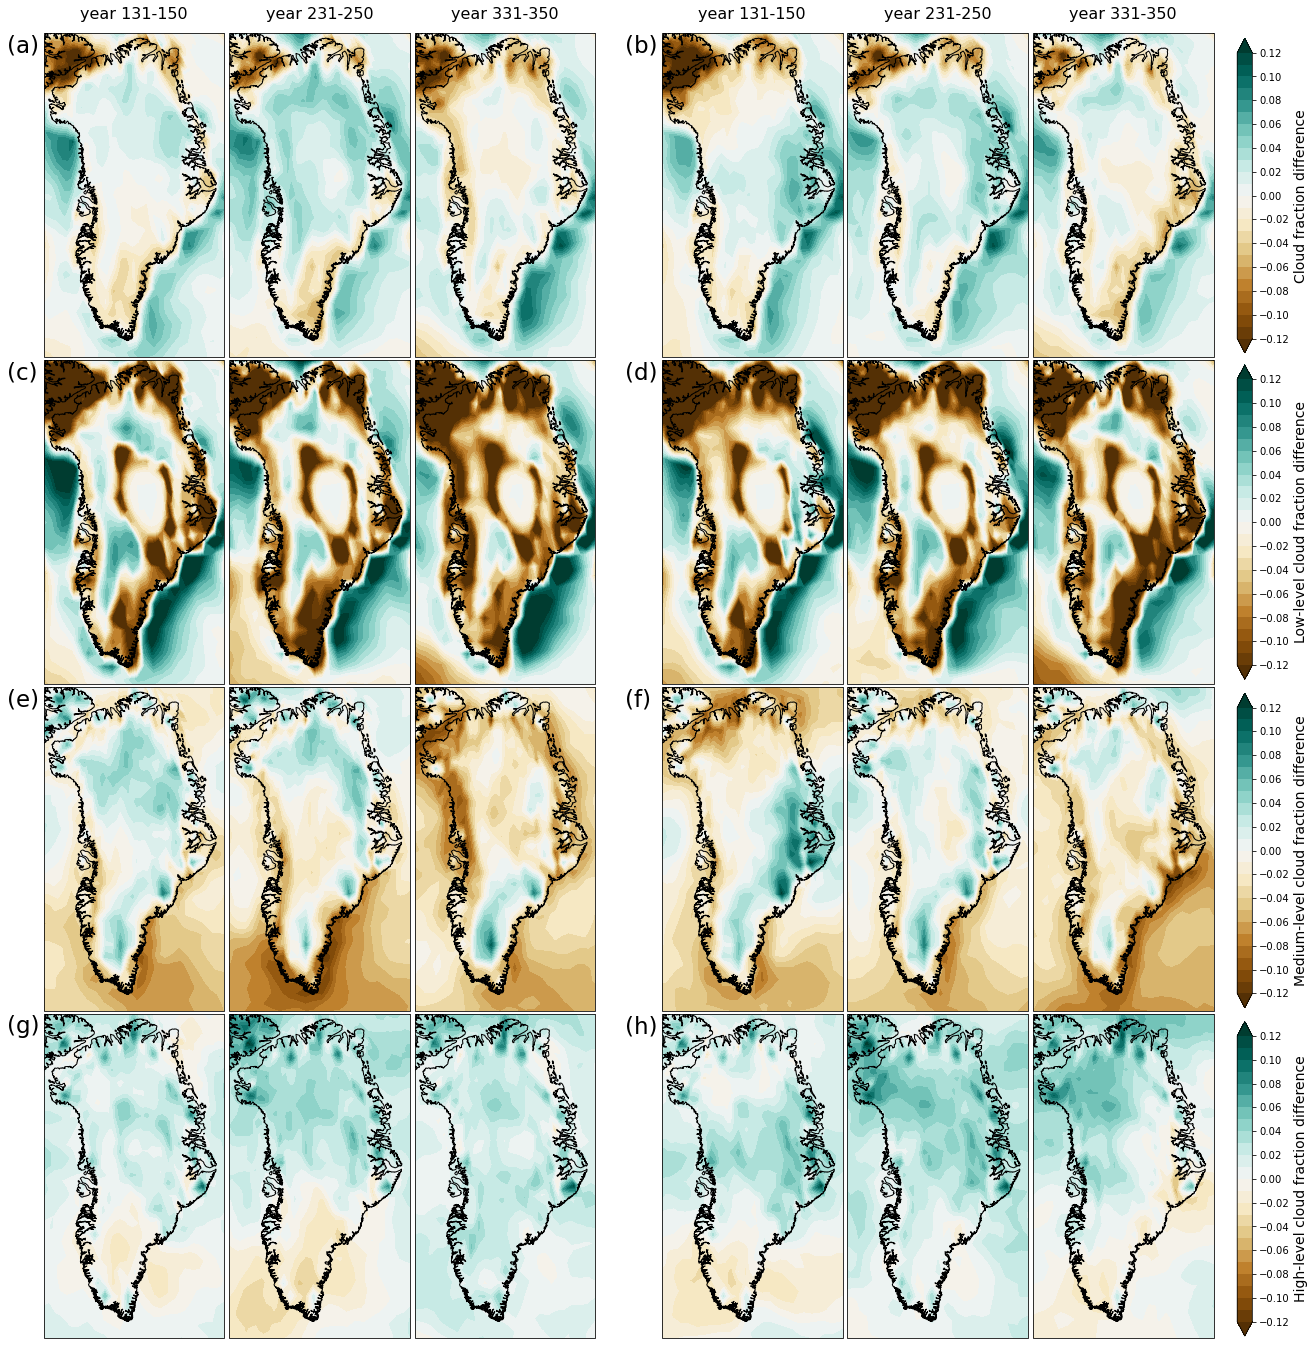

In [111]:
# Revision
fig = plt.figure(figsize = (21,24))
gs=GridSpec(12,19)
plt.rcParams['axes.titlepad'] =14

# Modify values here
cmap1 = plt.cm.BrBG
bounds1 = np.arange(-0.12,0.121,0.01)
bounds1min = [-100]
bounds1max = [100]
norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N, extend='both')
ticks1 = np.arange(-0.12,0.121,0.02)

cmap2 = plt.cm.BrBG
bounds2 = np.arange(-0.12,0.121,0.01)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-0.12,0.121,0.02)

#----------------------------line 1----------------------------
ax1 = plt.subplot(gs[0:3,0:3], projection=polar_stereographic)
ax1.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax1.coastlines(resolution='10m', zorder=7)
im1 = ax1.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax1.text(-1000000, -800000, '(a)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax2 = plt.subplot(gs[0:3,3:6], projection=polar_stereographic)
ax2.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax2.coastlines(resolution='10m', zorder=7)
im2 = ax2.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax3 = plt.subplot(gs[0:3,6:9], projection=polar_stereographic)
ax3.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax3.coastlines(resolution='10m', zorder=7)
im3 = ax3.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDTOT_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

ax4 = plt.subplot(gs[0:3,10:13], projection=polar_stereographic)
ax4.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax4.coastlines(resolution='10m', zorder=7)
im4 = ax4.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_stab2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 131-150', fontsize = 16)
ax4.text(-1000000, -800000, '(b)', fontsize=23)

ax5 = plt.subplot(gs[0:3,13:16], projection=polar_stereographic)
ax5.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax5.coastlines(resolution='10m', zorder=7)
im5 = ax5.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_mid2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 231-250', fontsize = 16)

ax6 = plt.subplot(gs[0:3,16:19], projection=polar_stereographic)
ax6.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax6.coastlines(resolution='10m', zorder=7)
im6 = ax6.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDTOT_diff_end2, cmap=cmap1, norm=norm1, levels=bounds1, extend='both', transform=crs_ll)
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title('year 331-350', fontsize = 16)

# colorbar
cbar_ax6 = fig.add_axes([0.915, 0.695, 0.01, 0.182])
cb6 = fig.colorbar(im6, cax=cbar_ax6, orientation='vertical', boundaries=bounds1min+bounds1+bounds1max, ticks=ticks1)
cb6.set_label(label='Cloud fraction difference', size=14)
cb6.ax.tick_params(labelsize=10)

#----------------------------line 2----------------------------
ax7 = plt.subplot(gs[3:6,0:3], projection=polar_stereographic)
ax7.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax7.coastlines(resolution='10m', zorder=7)
im7 = ax7.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDLOW_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax7.text(-1000000, -800000, '(c)', fontsize=23)
#plt.text(-900000, -2750000, 'F09M - ARCTIC', rotation=90, fontsize=24)

ax8 = plt.subplot(gs[3:6,3:6], projection=polar_stereographic)
ax8.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax8.coastlines(resolution='10m', zorder=7)
im8 = ax8.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDLOW_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax8.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax8.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax9 = plt.subplot(gs[3:6,6:9], projection=polar_stereographic)
ax9.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax9.coastlines(resolution='10m', zorder=7)
im9 = ax9.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDLOW_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax9.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax9.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax10 = plt.subplot(gs[3:6,10:13], projection=polar_stereographic)
ax10.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax10.coastlines(resolution='10m', zorder=7)
im10 = ax10.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDLOW_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax10.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax10.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax10.text(-1000000, -800000, '(d)', fontsize=23)

ax11 = plt.subplot(gs[3:6,13:16], projection=polar_stereographic)
ax11.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax11.coastlines(resolution='10m', zorder=7)
im11 = ax11.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDLOW_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax12 = plt.subplot(gs[3:6,16:19], projection=polar_stereographic)
ax12.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax12.coastlines(resolution='10m', zorder=7)
im12 = ax12.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDLOW_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax12 = fig.add_axes([0.915, 0.506, 0.01, 0.182])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Low-level cloud fraction difference', size=14)
cb12.ax.tick_params(labelsize=10)

#----------------------------line 3----------------------------
ax13 = plt.subplot(gs[6:9,0:3], projection=polar_stereographic)
ax13.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax13.coastlines(resolution='10m', zorder=7)
im13 = ax13.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDMED_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax13.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax13.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax13.text(-1000000, -800000, '(e)', fontsize=23)

ax14 = plt.subplot(gs[6:9,3:6], projection=polar_stereographic)
ax14.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax14.coastlines(resolution='10m', zorder=7)
im14 = ax14.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDMED_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax14.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax14.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax15 = plt.subplot(gs[6:9,6:9], projection=polar_stereographic)
ax15.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax15.coastlines(resolution='10m', zorder=7)
im15 = ax15.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDMED_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax15.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax15.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax16 = plt.subplot(gs[6:9,10:13], projection=polar_stereographic)
ax16.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax16.coastlines(resolution='10m', zorder=7)
im16 = ax16.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDMED_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax16.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax16.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax16.text(-1000000, -800000, '(f)', fontsize=23)

ax17 = plt.subplot(gs[6:9,13:16], projection=polar_stereographic)
ax17.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax17.coastlines(resolution='10m', zorder=7)
im17 = ax17.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDMED_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax17.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax17.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax18 = plt.subplot(gs[6:9,16:19], projection=polar_stereographic)
ax18.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax18.coastlines(resolution='10m', zorder=7)
im18 = ax18.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDMED_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax18.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax18.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax18 = fig.add_axes([0.915, 0.316, 0.01, 0.182])
cb18 = fig.colorbar(im18, cax=cbar_ax18, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb18.set_label(label='Medium-level cloud fraction difference', size=14)
cb18.ax.tick_params(labelsize=10)

#----------------------------line 4----------------------------
ax19 = plt.subplot(gs[9:12,0:3], projection=polar_stereographic)
ax19.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax19.coastlines(resolution='10m', zorder=7)
im19 = ax19.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDHGH_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax19.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax19.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax19.text(-1000000, -800000, '(g)', fontsize=23)

ax20 = plt.subplot(gs[9:12,3:6], projection=polar_stereographic)
ax20.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax20.coastlines(resolution='10m', zorder=7)
im20 = ax20.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDHGH_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax20.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax20.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax21 = plt.subplot(gs[9:12,6:9], projection=polar_stereographic)
ax21.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax21.coastlines(resolution='10m', zorder=7)
im21 = ax21.contourf(f09_lon2, f09_lat, ARCTIC_f09_CLDHGH_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax21.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax22 = plt.subplot(gs[9:12,10:13], projection=polar_stereographic)
ax22.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax22.coastlines(resolution='10m', zorder=7)
im22 = ax22.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDHGH_diff_stab2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax22.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax22.text(-1000000, -800000, '(h)', fontsize=23)

ax23 = plt.subplot(gs[9:12,13:16], projection=polar_stereographic)
ax23.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax23.coastlines(resolution='10m', zorder=7)
im23 = ax23.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDHGH_diff_mid2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax23.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax23.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

ax24 = plt.subplot(gs[9:12,16:19], projection=polar_stereographic)
ax24.set_extent([-56, -30, 58, 84]) # Map bounds, [west, east, south, north]
ax24.coastlines(resolution='10m', zorder=7)
im24 = ax24.contourf(f09_lon2, f09_lat, ARCTIC_f09_nohacks_CLDHGH_diff_end2, cmap=cmap2, norm=norm2, levels=bounds2, extend='both', transform=crs_ll)
ax24.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax24.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax24 = fig.add_axes([0.915, 0.126, 0.01, 0.182])
cb24 = fig.colorbar(im24, cax=cbar_ax24, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb24.set_label(label='High-level cloud fraction difference', size=14)
cb24.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.03)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Map_cloudfrac_difflevel_diff.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)